In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os, sys
os.chdir('/content/drive/MyDrive/lock_exchange')

Mounted at /content/drive/


In [ ]:
# import meshio
import numpy as np
from scipy import stats
import os, sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# from scipy.interpolate import interp1d
from scipy.interpolate import griddata
import time

from copy import deepcopy as cp
from sklearn.linear_model import Lasso
from scipy.integrate import solve_ivp
from math import sqrt
from joblib import Parallel, delayed

from copy import deepcopy as cp
import numpy as np
from sklearn.decomposition import PCA

import pandas as pd
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Add, Reshape
from keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tqdm
import os, sys
import urllib.request



from scipy import stats
from process import *

In [ ]:
sys.path.append('/content/drive/MyDrive/lock_exchange/src/')
from utils_plot import *  # contour
from utils_sindy import *
from loops import *
from process import *
from autoencoder import *

# lock_exchange


In [ ]:
model_name = './sae_u_2000_relu_version.hdf5'
input_dim = 128*64
layer_dim = [64*16,16*8,10*4,15,2]
latent_dim = 2
active = 'relu'

In [ ]:
os.chdir('/content/drive/MyDrive/1cylinder/Model/')
autoencoder_sae, encoder_sae, decoder_sae = load_autoencoder(model_name, input_dim, latent_dim)

### ROM-SAE+POD-SINDy

#### data

In [ ]:
r = np.load('./Model/r.npy')
Xor = cp(r)
r_min = np.min(Xor,axis=0)
r_max = np.max(Xor,axis=0)
# for i in range(len(Xor)):
#   Xor[i,:] = (2*Xor[i,:]-r_max-r_min)/(r_max-r_min)

# 判断是否有Nan
# for i in range(len(Xor)):
#   for j in range(2):
#     if np.isnan(Xor[i,j]):
#       print(i,j)

# np.save(os.path.join(store_path,'Xor.npy'),Xor)
# Xor = np.load(os.path.join(store_path,'Xor.npy'))

In [ ]:
# n_ts = 201
dt = 0.05
n_ts = 800

r1 = cp(Xor[0:n_ts,0])
# r2 = cp(Xor[0:n_ts:,1])

data = np.zeros([len(r1)-2,1])

data[:,0] = r1[1:len(r1)-1] # data.shape=(1998,2)
# data[:,1] = r2[1:len(r1)-1]

print(data.shape)

ddata=np.empty_like(data)
for i in range(len(r1)-2):
    ddata[i,0]=(r1[i+2]-r1[i])/(2*dt)
    # ddata[i,1]=(r2[i+2]-r2[i])/(2*dt)
# 2nd-order
print(ddata.shape)

(798, 1)
(798, 1)


In [ ]:
dtsnap = 0.05
taxx=np.arange(0,dtsnap*n_ts,dtsnap)
tax=np.arange(dtsnap,dtsnap*(n_ts-1)-1e-5,dtsnap)  # 1000
# tax=np.arange(dtsnap,dtsnap*(n_ts-2)+1e-5,dtsnap)
# tax=np.arange(dtsnap,dtsnap*(n_ts-1),dtsnap)
print(tax.shape)
print(taxx.shape)
print(data.shape)

(798,)
(800,)
(798, 1)


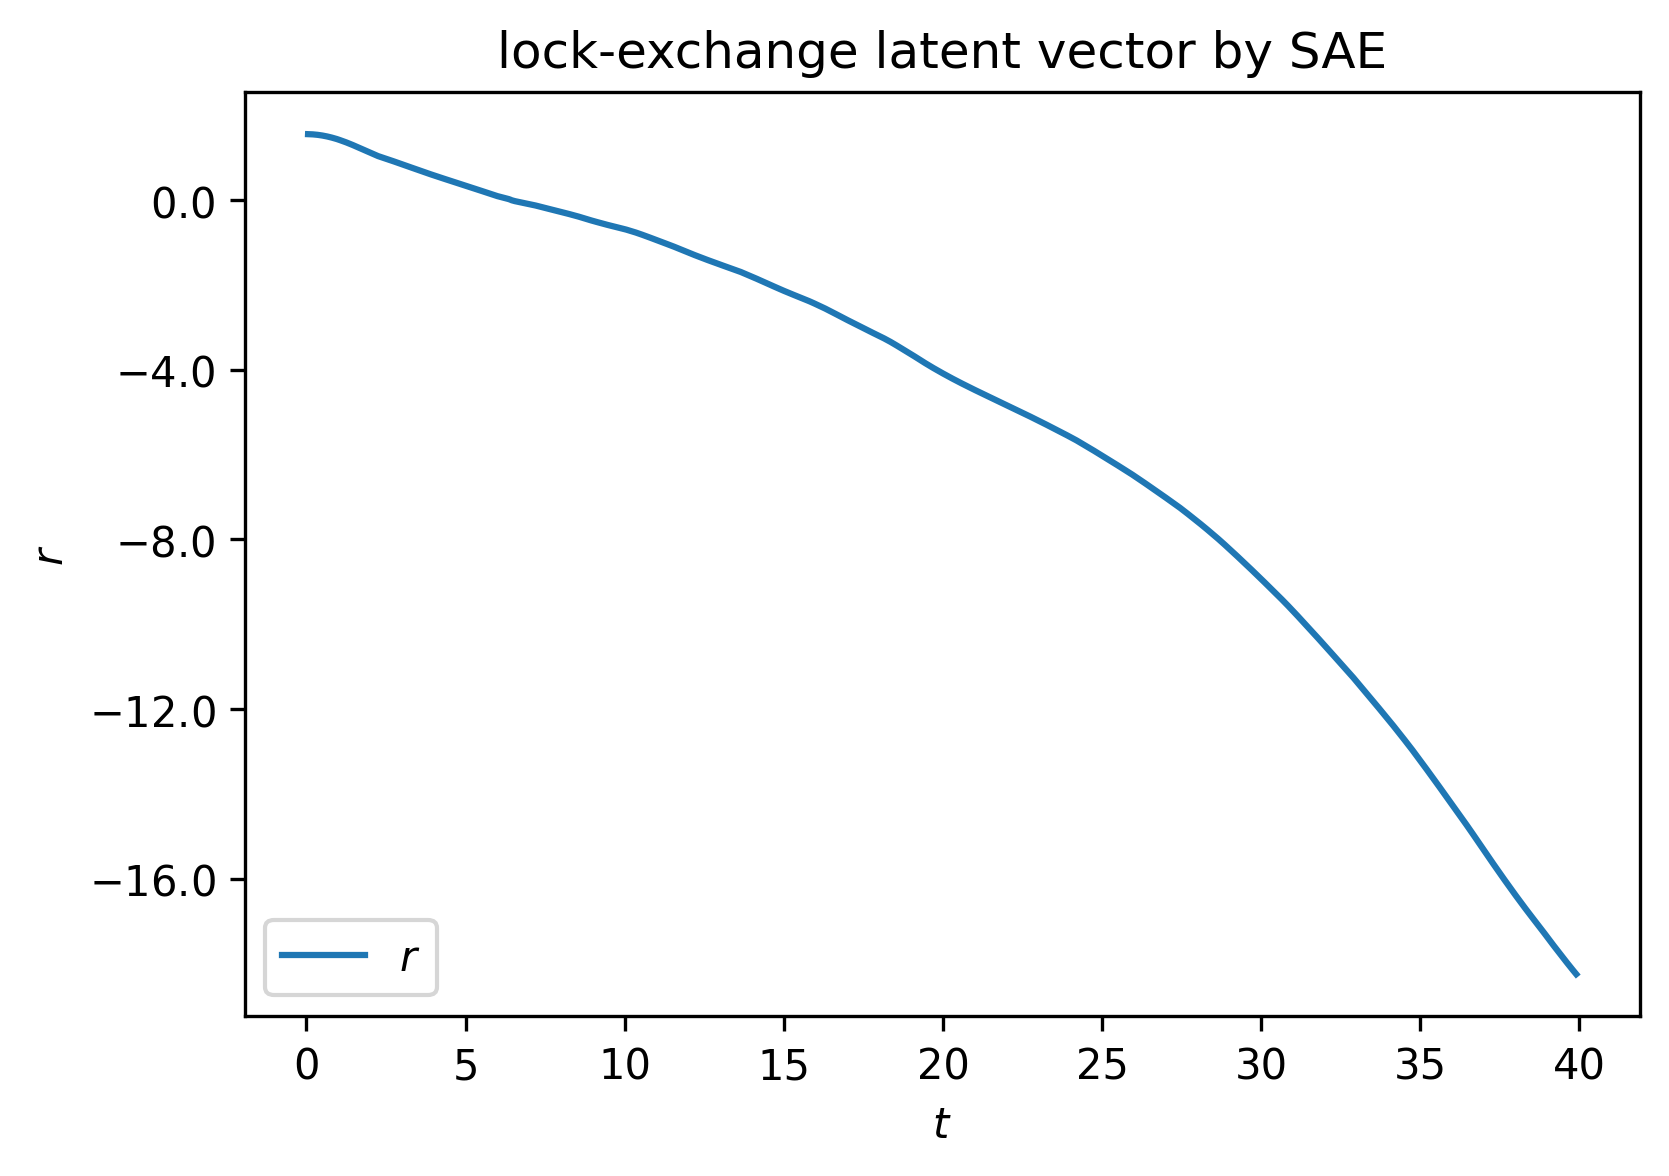

In [ ]:
fig=plt.figure(dpi=300,figsize=(6,4))
plt.plot(tax,data[:],label=r'$r$')
plt.legend(loc='lower left')
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
plt.xlabel(r'$t$')
plt.ylabel(r'$r$')
plt.yticks(ticks=[0.0,-4,-8,-12,-16],\
            labels=["$0.0$","$-4.0$","$-8.0$","$-12.0$","$-16.0$",])
# plt.ylabel(r'Value',fontsize=20)
# plt.ylim([-50,50])
plt.title('lock-exchange latent vector by SAE')
# plt.savefig("/content/drive/MyDrive/fig/lock_exchange/le_sae_latent.png",bbox_inches='tight')
plt.show()

In [ ]:
data_sae = data
ddata_sae = ddata
data_sae = np.save('./Model/data_sae.npy')
data_sae = np.save('./Model/data_sae.npy')

#### sae - pod

In [ ]:
Xor = cp(r)
r_min = np.min(Xor,axis=0)
r_max = np.max(Xor,axis=0)
# for i in range(len(Xor)):
#   Xor[i,:] = (2*Xor[i,:]-r_max-r_min)/(r_max-r_min)

# for i in range(len(Xor)):
#   for j in range(2):
#     if np.isnan(Xor[i,j]):
#       print(i,j)

# np.save(os.path.join(store_path,'Xor.npy'),Xor)
# Xor = np.load(os.path.join(store_path,'Xor.npy'))

In [ ]:
# Xor = cp(Xor2)
print(Xor.shape)
sae_pca = PCA(n_components=1)
Xor2 = sae_pca.fit_transform(Xor)
print(Xor2.shape)
# print(pca1.explained_variance_ratio_)
re_Xor = sae_pca.inverse_transform(Xor2)
print(1-np.linalg.norm(re_Xor-Xor)/np.linalg.norm(Xor))

(800, 1)
(800, 1)
0.99999994636309


In [ ]:
# Xor1 = cp(rr)
Xor1 = cp(Xor2)
r_min12 = np.min(Xor1,axis=0)
r_max12 = np.max(Xor1,axis=0)
# for i in range(len(Xor1)):
#   Xor1[i,:] = (2*Xor1[i,:]-r_max12-r_min12)/(r_max12-r_min12)

In [ ]:
# n_ts = 201
dt = 0.05


r1 = cp(Xor1[0:n_ts,0])
# r2 = cp(Xor1[0:n_ts:,1])


data = np.zeros([len(r1)-2,1])

data[:,0] = r1[1:len(r1)-1] # data.shape=(1998,2)
# data[:,1] = r2[1:len(r1)-1]

print(data.shape)

ddata=np.empty_like(data)
for i in range(len(r1)-2):
    ddata[i,0]=(r1[i+2]-r1[i])/(2*dt)
    # ddata[i,1]=(r2[i+2]-r2[i])/(2*dt)
# 2nd-order
print(ddata.shape)

(798, 1)
(798, 1)


In [ ]:
# n_ts = 201
dtsnap = 0.05
taxx=np.arange(0,dtsnap*n_ts,dtsnap)
tax=np.arange(dtsnap,dtsnap*(n_ts-1)-1e-5,dtsnap)  # 1000
# tax=np.arange(dtsnap,dtsnap*(n_ts-2)+1e-5,dtsnap)
# tax=np.arange(dtsnap,dtsnap*(n_ts-1),dtsnap)
print(tax.shape)
print(taxx.shape)
print(data.shape)

(798,)
(800,)
(798, 1)


In [ ]:
data_sae_pod = data
ddata_sae_pod = ddata
np.save('./Model/data_sae_pod.npy', data_sae_pod)
np.save('./Model/ddata_sae_pod.npy', ddata_sae_pod)

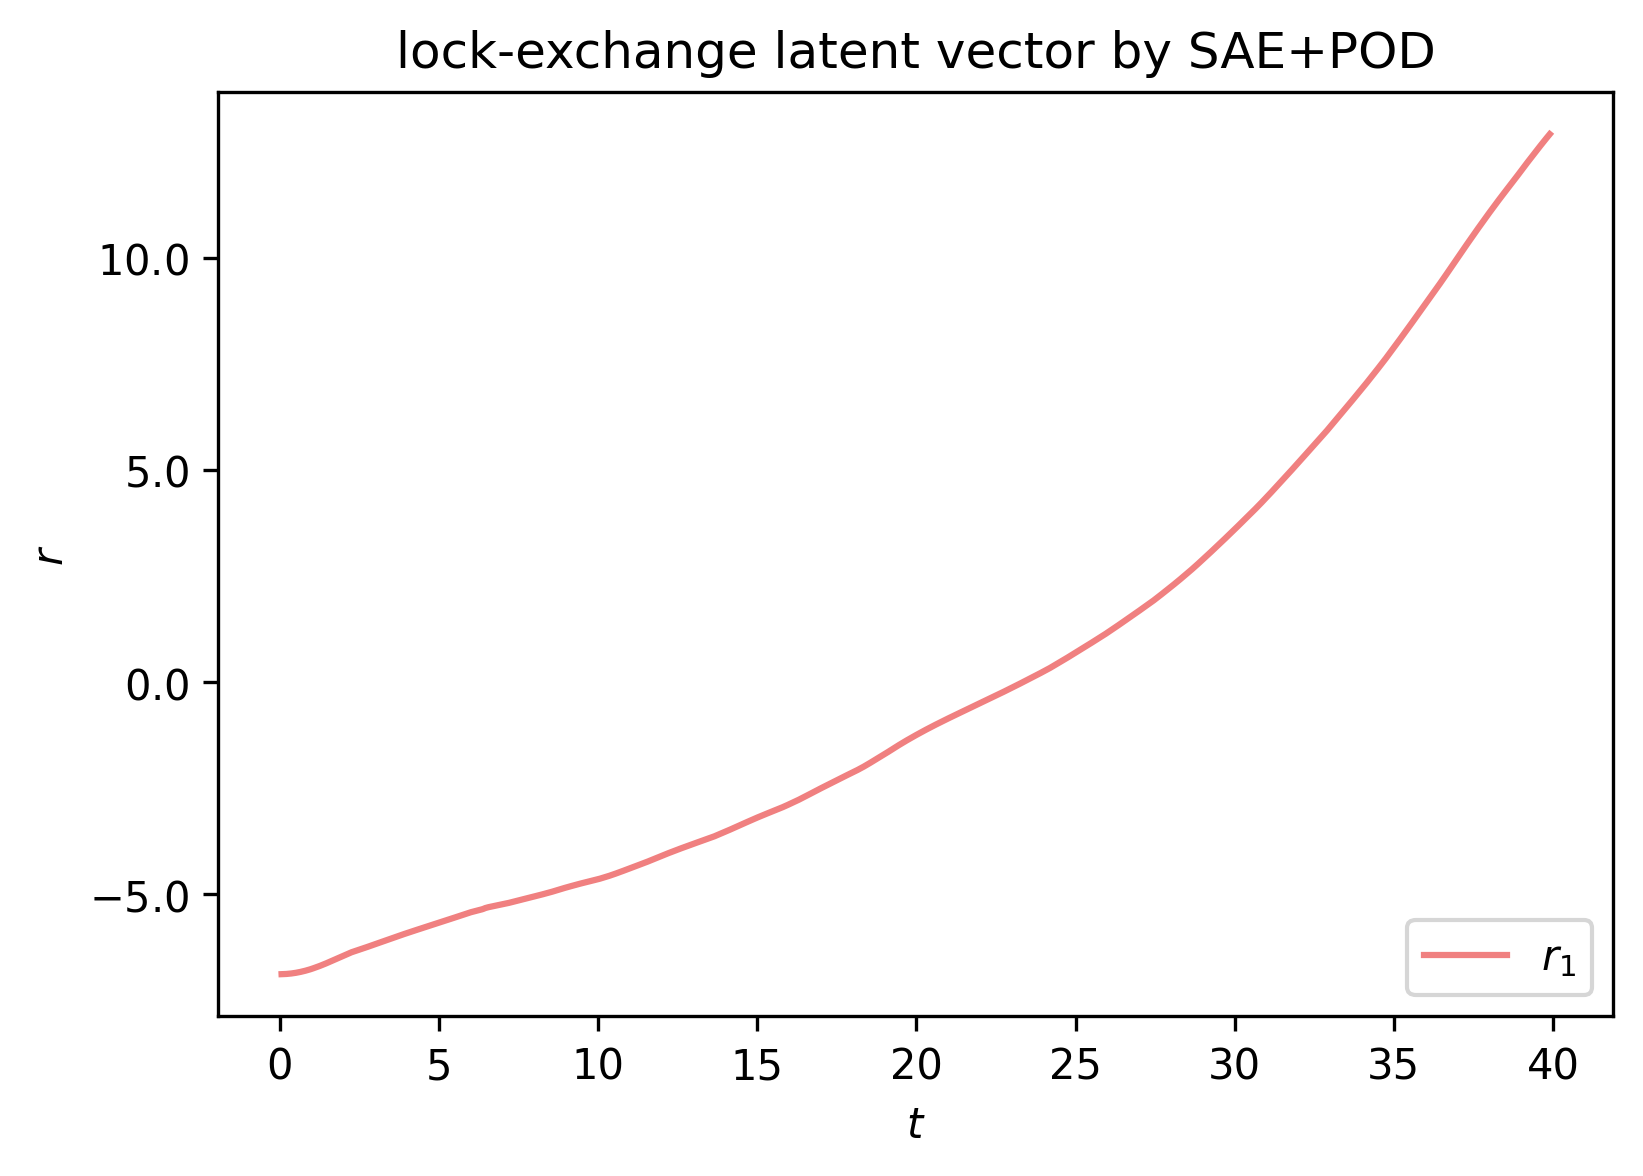

In [ ]:
data = cp(data_sae_pod)
fig=plt.figure(dpi=300,figsize=(6,4))
plt.plot(tax,data[:],label=r'$r_1$',color='lightcoral')
# plt.plot(tax,r2[2:],label=r'$r_2$')
# plt.plot(tax,r3[2:],label=r'$r_3$')
# plt.plot(tax,r4[2:],label=r'$r_4$')
# plt.plot(tax,r5[2:],label=r'$r_5$')
# plt.plot(tax,r6[2:],label=r'$r_6$')
# plt.xlim([-1,20])
plt.legend(loc='lower right')
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
plt.xlabel(r'$t$')
plt.ylabel(r'$r$')
plt.yticks(ticks=[-5,0,5,10],\
            labels=["$-5.0$","$0.0$","$5.0$","$10.0$"])
# plt.savefig("/content/drive/MyDrive/fig/lock_exchange/le_sae_latent.png",bbox_inches='tight')
plt.show()

In [ ]:
n_order = 3   # 5
k = 2
LHS = cp(ddata)
RHS = RHS_rk(data,n_order)
print(LHS.shape)
print(RHS.shape)

In [ ]:
alr = np.array([\
                1e-9,2e-9,3e-9,4e-9,5e-9,6e-9,7e-9,8e-9,9e-9,\
                1e-8,2e-8,3e-8,4e-8,5e-8,6e-8,7e-8,8e-8,9e-8,\
                1e-7,2e-7,3e-7,4e-7,5e-7,6e-7,7e-7,8e-7,9e-7,\
                1e-6,2e-6,3e-6,4e-6,5e-6,6e-6,7e-6,8e-6,9e-6,\
                1e-5,2e-5,3e-5,4e-5,5e-5,6e-5,7e-5,8e-5,9e-5,\
                1e-4,2e-4,3e-4,4e-4,5e-4,6e-4,7e-4,8e-4,9e-4,\
                # 1e-3,2e-3,3e-3,4e-3,5e-3,6e-3,7e-3,8e-3,9e-3,\
                ])

rms11 = np.zeros_like(alr)
mean11 = np.zeros_like(alr)
nxcmp1 = np.zeros_like(alr)
nycmp1 = np.zeros_like(alr)
aic11 = np.zeros_like(alr)
starray = np.zeros_like(alr)
sig = np.ones_like(alr)
L2_error = np.ones_like(alr)

PCC_list_sae = np.ones_like(alr)
RMSE_list_sae = np.ones_like(alr)
PCC_list_sae_pod = np.ones_like(alr)
RMSE_list_sae_pod = np.ones_like(alr)

In [ ]:
xi12 = alasso(RHS,LHS[:,0],alr[0])
print(xi12.shape)
print(xi12)
print(np.count_nonzero(xi12))

xi12 = alasso(RHS,LHS[:,0],alr[30])
print(xi12.shape)
print(xi12)
print(np.count_nonzero(xi12))

(35,)
[ 0.45678792 -0.63850275 -0.32253899  0.50680852  0.21736629  0.16361523
  0.13970606 -0.72305879  0.2645492  -0.13856003 -1.34682923 -0.09336999
  0.34156629 -0.76211337  0.          0.32742846 -0.67338926  0.05880314
  0.54312341  0.78906575 -0.04702068  0.14905065 -0.00780484  1.04246827
 -0.20862495  1.28809837  0.33694437  1.2040501   1.41154529  0.
 -0.38721625  0.53839264 -0.75543735  0.24821274  0.07497137]
33
(35,)
[ 0.45666093 -0.64298812 -0.32207662  0.51909522  0.2014942   0.15336045
  0.16613051 -0.71719998  0.27591683 -0.10759913 -1.36400439 -0.05319813
  0.32164837 -0.73146581 -0.          0.34779981 -0.63876458  0.
  0.51627321  0.76634626 -0.          0.11689308 -0.          1.00608838
 -0.13577928  1.24815341  0.29671557  1.27304841  1.42236578 -0.
 -0.39123645  0.52928627 -0.71145626  0.29903389  0.        ]
29


In [ ]:
xi1 = tlsa_norm(RHS,LHS[:,0],alr[0])
# print(xi1.shape)
print(xi1)
print(np.count_nonzero(xi1))

# xi1 = tlsa_norm(RHS,LHS[:,0],alr[53])
xi1 = tlsa_norm(RHS,LHS[:,0],alr[50])
# print(xi1.shape)
print(xi1)
print(np.count_nonzero(xi1))

[ 4.56778287e-01 -6.38501494e-01 -3.22532750e-01  5.06769078e-01
  2.17367902e-01  1.63666425e-01  1.39655403e-01 -7.23023286e-01
  2.64494754e-01 -1.38551873e-01 -1.34677172e+00 -9.34904715e-02
  3.41804118e-01 -7.62081754e-01  1.89711257e-04  3.27432783e-01
 -6.73361281e-01  5.90331594e-02  5.43000876e-01  7.88841869e-01
 -4.70654685e-02  1.49179259e-01 -8.19260635e-03  1.04243477e+00
 -2.08920823e-01  1.28805063e+00  3.36589371e-01  1.20412530e+00
  1.41222723e+00  1.10189111e-03 -3.87099633e-01  5.38242925e-01
 -7.55676552e-01  2.47706642e-01  7.50675719e-02]
35
[ 4.56778287e-01 -6.38501494e-01 -3.22532750e-01  5.06769078e-01
  2.17367902e-01  1.63666425e-01  1.39655403e-01 -7.23023286e-01
  2.64494754e-01 -1.38551873e-01 -1.34677172e+00 -9.34904715e-02
  3.41804118e-01 -7.62081754e-01  1.89711257e-04  3.27432783e-01
 -6.73361281e-01  5.90331594e-02  5.43000876e-01  7.88841869e-01
 -4.70654685e-02  1.49179259e-01 -8.19260635e-03  1.04243477e+00
 -2.08920823e-01  1.28805063e+00  3.3

In [ ]:
# alaaso
n_order = 3   # 5
usesin = False
usfl = 0
n=0


stat = 0.05
endt = 0.05*(n_ts-2)
taxint = np.arange(stat,endt+1e-5,dt)
dtff = cp(dt)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

n=10
# alpha, xi, vodet, vodey, draw = cal_sindy_k(n,data_pca[-n_ts:,:],ddata_pca[-n_ts:,:],alr)
alpha, xi, vodet, vodey, draw = cal_sindy_k(n,data,ddata,alr)
print(xi)

count_nonzero(xi):  16
[[-0.04712 -0.1456 ]
 [ 0.06714 -0.     ]
 [-0.0731   0.2001 ]
 [-0.2325   0.1451 ]
 [-0.2391   0.1978 ]
 [ 0.       0.177  ]
 [-0.      -0.     ]
 [ 0.0559   0.1566 ]
 [-0.07825 -0.2172 ]
 [ 0.2051  -0.1512 ]]


In [ ]:
data = data_sae_pod
ddata = ddata_sae_pod

delta = 2
# n_ts=2000，u
n_order=3

usesin = False
uset = True
usesint = False

import warnings
warnings.filterwarnings("ignore")

from scipy import stats

# def AIC(data,vodey,vodet):
# def rms_and_mean(vodey,vodet):   return mean1,rms1

print('mean,rms',rms_and_mean(data.T,taxint))


for n in range(len(alr)):
  alpha, xi, vodet, vodey, num_r1, draw, aic, mean1, rms1, L2_error1=loop1(n,data,ddata,alr)
  if ~np.isnan(draw):
    p1 = stats.pearsonr(vodey[0,:].T, data[:,0])[0]
    print('PCC',p1)
    PCC_list_sae_pod[n] = p1
    RMSE = np.sqrt(((vodey.T-data) ** 2).mean())
    print('RMSE',RMSE)
    RMSE_list_sae_pod[n] = RMSE
  print("n",n,"alpha",alpha)
  # print(draw)
  print('n_r1:',num_r1)
  print('aic',aic)
  print('mean1,rms1',mean1,rms1)
  print('L2_error1',L2_error1)
  rms11[n] = rms1
  mean11[n] = mean1
  nxcmp1[n] = num_r1
  aic11[n] = aic
  L2_error[n] =L2_error1

  if ~np.isnan(num_r1):

    # Original and reproduced time history

    # fig=plt.figure(dpi=300,figsize=(8,2))
    fig=plt.figure(dpi=300,figsize=(6,2))

    # plt.axes([0.1,0.5,0.8,0.5])
    plt.plot(taxint,data[:],lw=1,label=r'$r$',color='darkgray')
    plt.plot(vodet,vodey[0,:],'--',label='Reproduced $r$')
    plt.legend(loc='lower right')
    # plt.grid(True)
    # plt.xticks(fontsize=15)
    # plt.yticks([-1,0,1],fontsize=15)
    plt.xlabel(r'$t$')
    plt.ylabel(r'$r_1$')


    plt.show()

In [ ]:
print('mean,rms',rms_and_mean(data.T,taxint))  # ???

mean,rms (-0.050584312614952054, 1.2309633276738166)


In [ ]:
alr2 = [7e=07,4e-06]
alr2 = [8e-09,5e-09,4e-09,3e-09]

### loop result

In [ ]:
a1=np.isnan(PCC_list_sae)
print(~a1)
a1 = ~a1
a2=np.isnan(PCC_list_sae_pod)
print(~a2)
a2 = ~a2

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


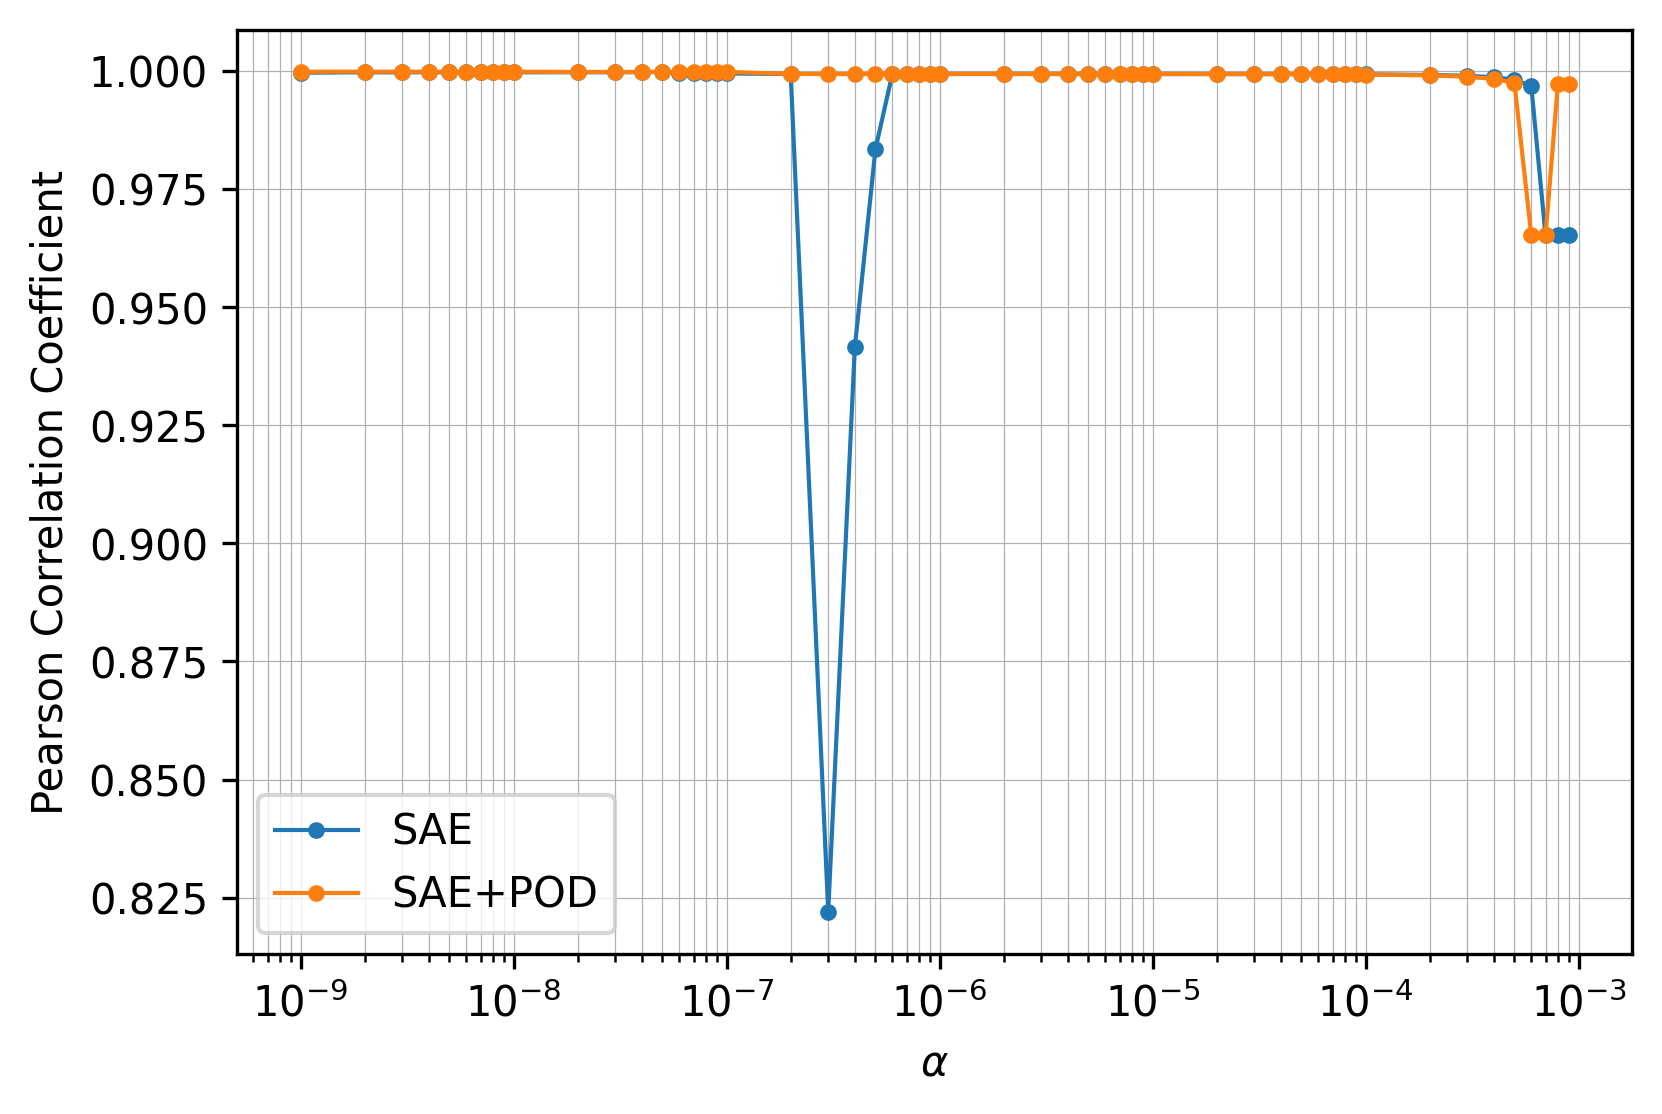

In [ ]:
plt.figure(dpi=300,figsize=(6,4))

plt.plot(alr[a1], PCC_list_sae[a1], '.-',lw=1.0,label='SAE')
plt.plot(alr[a2], PCC_list_sae_pod[a2], '.-',lw=1.0,label='SAE+POD')
# plt.plot(taxint,data_pca[:,2],lw=1,label=r'$r_3$',color='darkgray')
# plt.plot(alr_ne, nx, 'x',label='Complexity')
plt.ylabel('Pearson Correlation Coefficient')
plt.xlabel(r'$\alpha$')
# plt.ylabel('Error rate', fontsize=fonts1)
# plt.xlabel(r'$\alpha$', fontsize=fonts1)
# plt.ylim([-5, 50])
# plt.xlim([1e-9, 1e-5])
plt.xscale('log')
# plt.yscale('log')
# plt.xticks(ticks=[1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3],\
            # labels=["$10^{-9}$","$10^{-8}$","$10^{-7}$","$10^{-6}$","$10^{-5}$","$10^{-4}$","$10^{-3}$"])
# plt.xticks(ticks=[1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1],\
#             labels=["","$10^{-8}$","","$10^{-6}$","","$10^{-4}$","","$10^{-2}$","","$1$"])
plt.grid(lw=0.3,which='both')
# plt.savefig('/content/drive/MyDrive/fig/lock_exchange/le_alpha_sae.png')
plt.legend()

In [ ]:
rmse_sae_pod_min = np.min(RMSE_list_sae_pod)
rmse_sae_pod_max = np.max(RMSE_list_sae_pod)
for i in range(len(RMSE_list_sae_pod)):
  RMSE_list_sae_pod[i] = (RMSE_list_sae_pod[i]-rmse_sae_pod_min)*2/(rmse_sae_pod_max-rmse_sae_pod_min)+0.0

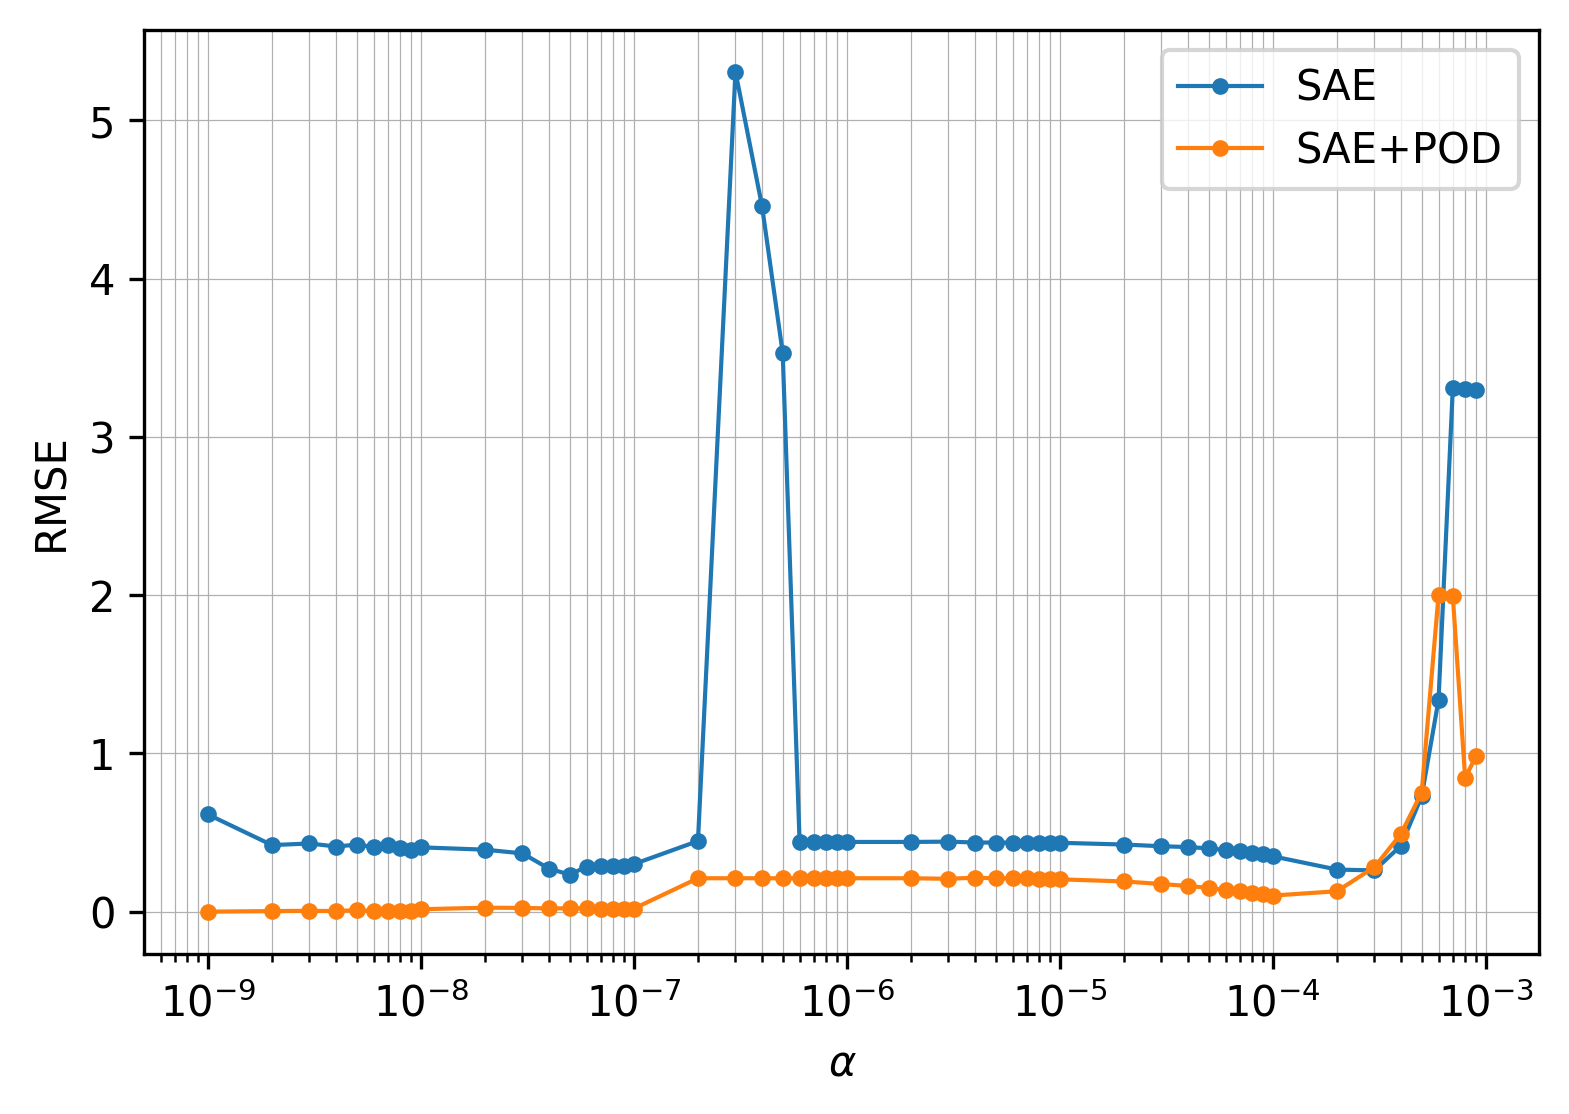

In [ ]:
plt.figure(dpi=300,figsize=(6,4))


# plt.scatter(alr_ne,err_rms,marker='o', c=nxcmp1[noerror], cmap='tab20', label='Amplitude' ,vmin=-0.5, vmax=19.5)
# plt.plot(alr_ne, err_mean, '.-',label='mean')
plt.plot(alr, RMSE_list_sae, '.-',lw=1.0,label='SAE')
plt.plot(alr, RMSE_list_sae_pod, '.-',lw=1.0,label='SAE+POD')
# plt.plot(taxint,data_pca[:,2],lw=1,label=r'$r_3$',color='darkgray')
# plt.plot(alr_ne, nx, 'x',label='Complexity')
plt.ylabel('RMSE')
plt.xlabel(r'$\alpha$')
# plt.ylabel('Error rate', fontsize=fonts1)
# plt.xlabel(r'$\alpha$', fontsize=fonts1)
# plt.ylim([-5, 50])
# plt.xlim([1e-9, 1e-5])
plt.xscale('log')
# plt.ylim([-0.1,2])
# plt.yscale('log')
# plt.xticks(ticks=[1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3],\
            # labels=["$10^{-9}$","$10^{-8}$","$10^{-7}$","$10^{-6}$","$10^{-5}$","$10^{-4}$","$10^{-3}$"])
# plt.xticks(ticks=[1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1],\
#             labels=["","$10^{-8}$","","$10^{-6}$","","$10^{-4}$","","$10^{-2}$","","$1$"])
plt.grid(lw=0.3,which='both')
# plt.savefig('/content/drive/MyDrive/fig/lock_exchange/le_alpha_sae.png')
plt.legend()

In [ ]:
a1=np.nonzero(nxcmp1)
# print(a1)
noerror = np.ones((len(alr),), dtype=bool)
noerror = ~noerror
noerror[a1] = True
print(noerror)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
 False False False False False False False False False False False False
 False False False]


In [ ]:
meanx=np.mean(data[:,:],axis=0)
meant=np.sum(meanx)

msx=np.zeros(k)
rmsx=np.zeros(k)
tempval=len(data[:,:])
for i in range(k):
  msx[i]=np.sum((data[:,i]-meanx[i])**2)
  rmsx[i]=np.sqrt(msx[i]/tempval)
rmst=np.sum(rmsx)

print(rmst,meant)
print(msx)
print(meanx)

1.2093818541036045 -0.1426607348352907
[208.5271095  229.78072847]
[-0.28966202  0.14700129]


In [ ]:
a1 = np.nonzero(nxcmp1)
a2 = np.isnan(L2_error)
# print(a1)
noerror = np.ones((len(alr),), dtype=bool)
noerror = ~noerror
noerror[a1] = True
noerror[a2] = False
print(noerror)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False]


### certain alpha



In [ ]:
usesint = False
# tax = np.arange(dtsnap,dtsnap*(n_ts-1)-1e-5,dtsnap)
# fre
n_order = 3
usesin = False
uset = True

In [ ]:
print(alr)

In [ ]:
stat = 0.05
endt = 0.05*(n_ts-2)
taxint = np.arange(stat,endt+1e-5,dt)

In [ ]:
alr2 = [1e-08]

In [ ]:
n_ts = 800
stat = 0.05 # tax.shape[0] = n_ts-2
endt = 0.05*(n_ts-2)
taxint = np.arange(stat,endt+1e-5,dt)
dtff = cp(dt) # 【？】

In [ ]:
n=10
alpha, xi, vodet, vodey, draw = cal_sindy_k(n,data,ddata,alr)

count_nonzero(xi):  17


In [ ]:
# aic = AIC(data,vodey,vodet,xi)
mean1,rms1 = rms_and_mean(vodey,vodet)

In [ ]:
data_sae = np.load('./Model/data_sae')
ddata_sae = np.load('./Model/ddata_sae')
data_sae_pod = np.load('./Model/data_sae_pod')
ddata_sae_pod = np.load('./Model/ddata_sae_pod')

mean,rms (-5.335512028780665, 5.43902381027992)
count_nonzero(xi):  5
PCC 0.9997310269031168
RMSE 0.40636601598832217
n 0 alpha 1e-08
n_r1: 5
aic -1427.1996092314218
mean1,rms1 -5.623890390090378 5.694580991503405
L2_error1 0.053335180357484004


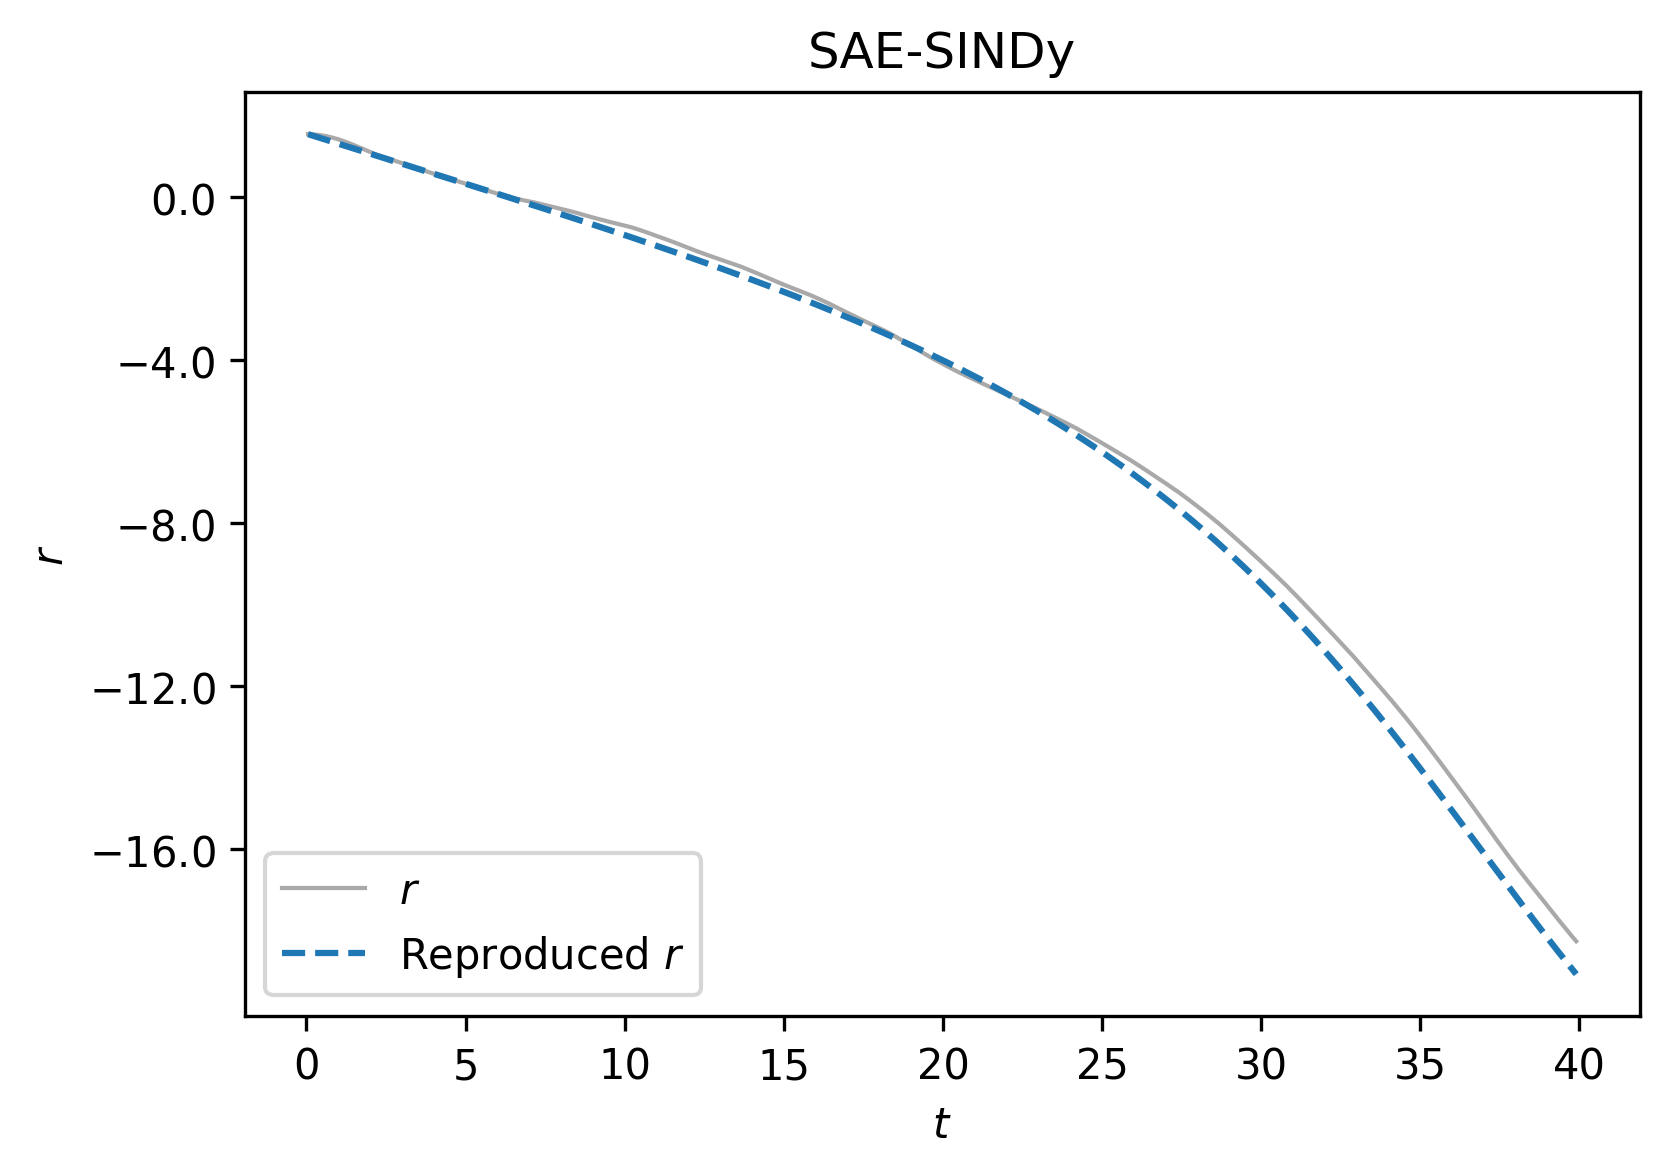

In [ ]:
data = data_sae
ddata = ddata_sae

delta = 2
# n_ts=2000，u
n_order=3

usesin = False
uset = True
usesint = False

import warnings
warnings.filterwarnings("ignore")

from scipy import stats

# def AIC(data,vodey,vodet):
# def rms_and_mean(vodey,vodet):   return mean1,rms1

print('mean,rms',rms_and_mean(data.T,taxint))


for n in range(len(alr2)):
  alpha, xi, vodet, vodey, num_r1, draw, aic, mean1, rms1, L2_error1=loop1(n,data,ddata,alr2)
  if ~np.isnan(draw):
    p1 = stats.pearsonr(vodey[0,:].T, data[:,0])[0]
    PCC_list_sae[n] = p1
    print('PCC',p1)
    RMSE = np.sqrt(((vodey.T-data) ** 2).mean())
    print('RMSE',RMSE)
    RMSE_list_sae[n] = RMSE
  print("n",n,"alpha",alpha)
  # print(draw)
  print('n_r1:',num_r1)
  print('aic',aic)
  print('mean1,rms1',mean1,rms1)
  print('L2_error1',L2_error1)
  rms11[n] = rms1
  mean11[n] = mean1
  nxcmp1[n] = num_r1
  aic11[n] = aic
  L2_error[n] =L2_error1

  if ~np.isnan(num_r1):

    # Original and reproduced time history

    # fig=plt.figure(dpi=300,figsize=(8,2))
    fig=plt.figure(dpi=300,figsize=(6,4))

    # plt.axes([0.1,0.5,0.8,0.5])
    plt.plot(taxint,data[:],lw=1,label=r'$r$',color='darkgray')
    plt.plot(vodet,vodey[0,:],'--',label='Reproduced $r$')
    plt.legend(loc='lower left')
    # plt.grid(True)
    # plt.xticks(fontsize=15)
    # plt.yticks([-1,0,1],fontsize=15)
    plt.xlabel(r'$t$')
    plt.ylabel(r'$r$')

    plt.yticks(ticks=[0.0,-4,-8,-12,-16],\
            labels=["$0.0$","$-4.0$","$-8.0$","$-12.0$","$-16.0$",])
    plt.title('SAE-SINDy')


    plt.show()

In [ ]:
vodey_sae = cp(vodey)

mean,rms (-0.007594260142621279, 5.43902399384055)
count_nonzero(xi):  5
PCC 0.9998595218962877
RMSE 0.11961893690980438
n 0 alpha 1e-08
n_r1: 5
aic -3379.016806954379
mean1,rms1 -0.05197520242627137 5.374792746462309
L2_error1 0.021992699507362917


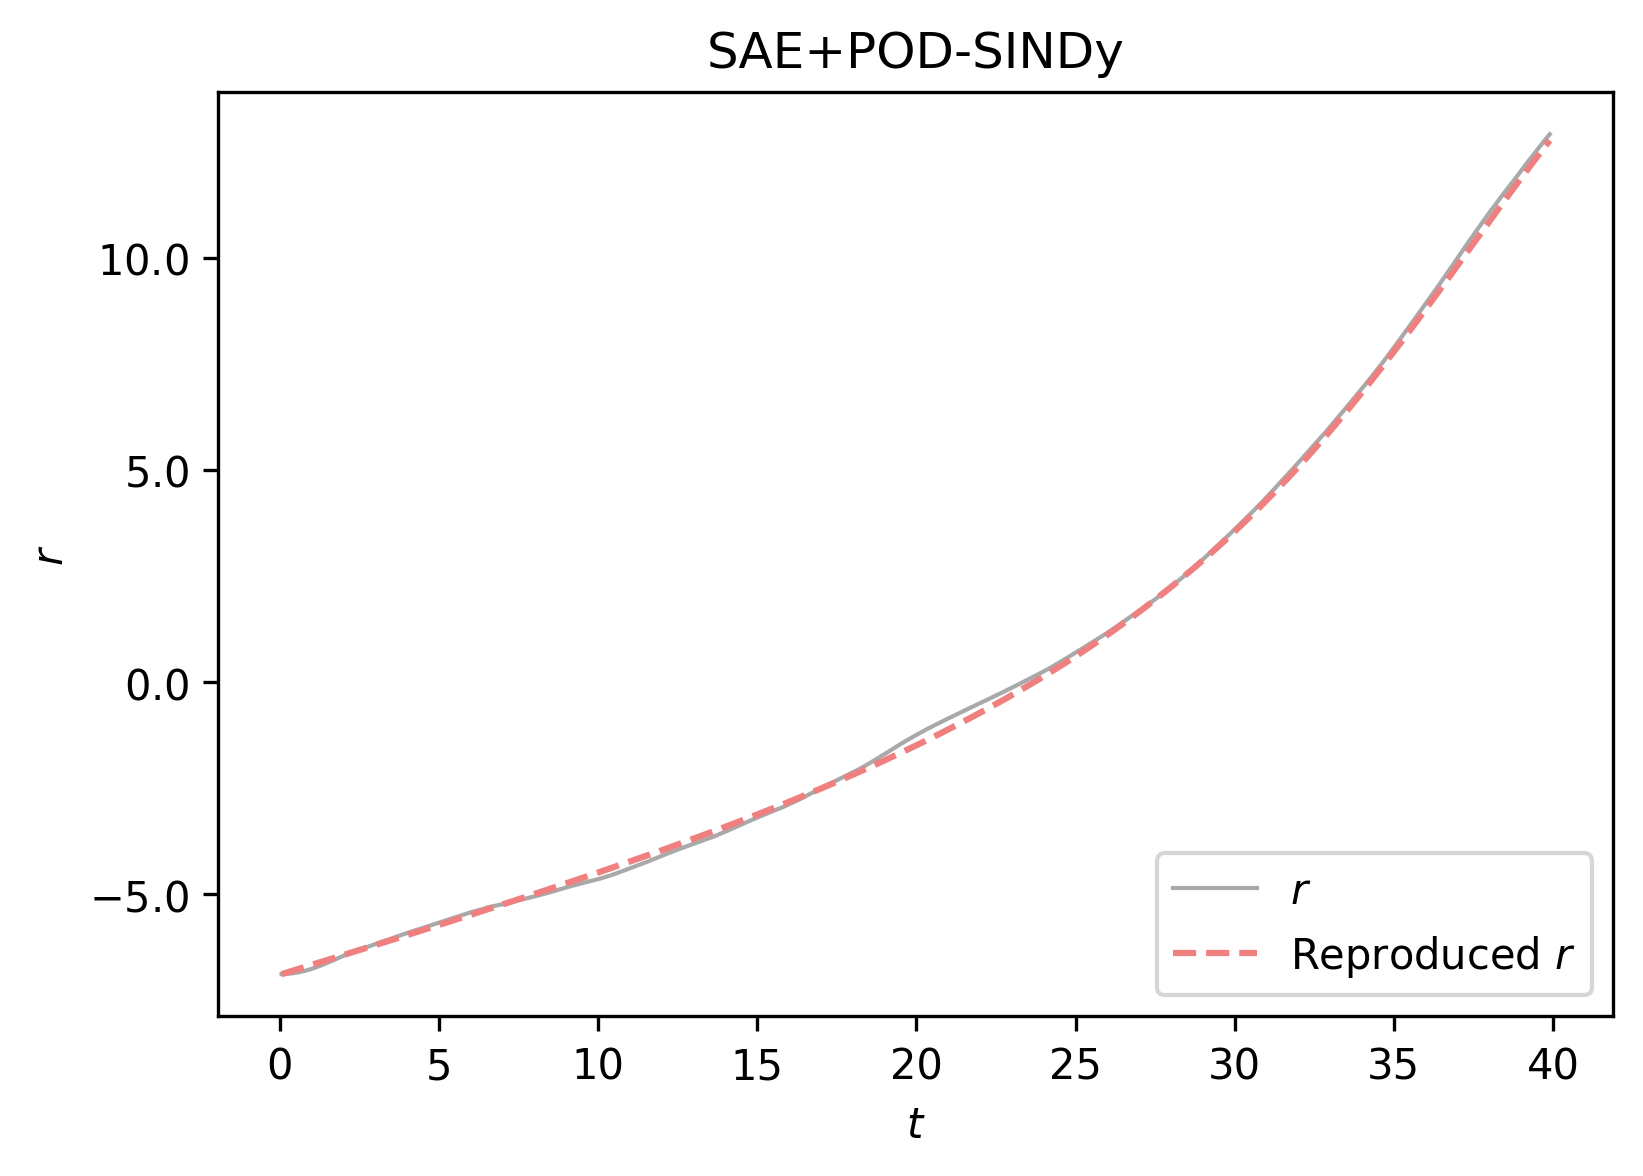

In [ ]:
data = data_sae_pod
ddata = ddata_sae_pod

delta = 2
# n_ts=2000，u
n_order=3

usesin = False
uset = True
usesint = False

import warnings
warnings.filterwarnings("ignore") # 忽略不收敛警告

from scipy import stats

# def AIC(data,vodey,vodet):
# def rms_and_mean(vodey,vodet):   return mean1,rms1

print('mean,rms',rms_and_mean(data.T,taxint))


for n in range(len(alr2)):
  alpha, xi, vodet, vodey, num_r1, draw, aic, mean1, rms1, L2_error1=loop1(n,data,ddata,alr2)
  if ~np.isnan(draw):
    p1 = stats.pearsonr(vodey[0,:].T, data[:,0])[0]
    PCC_list_sae[n] = p1
    print('PCC',p1)
    RMSE = np.sqrt(((vodey.T-data) ** 2).mean())
    print('RMSE',RMSE)
    RMSE_list_sae[n] = RMSE
  print("n",n,"alpha",alpha)
  # print(draw)
  print('n_r1:',num_r1)
  print('aic',aic)
  print('mean1,rms1',mean1,rms1)
  print('L2_error1',L2_error1)
  rms11[n] = rms1
  mean11[n] = mean1
  nxcmp1[n] = num_r1
  aic11[n] = aic
  L2_error[n] =L2_error1

  if ~np.isnan(num_r1):

    # Original and reproduced time history

    # fig=plt.figure(dpi=300,figsize=(8,2))
    fig=plt.figure(dpi=300,figsize=(6,4))

    # plt.axes([0.1,0.5,0.8,0.5])
    plt.plot(taxint,data[:],lw=1,label=r'$r$',color='darkgray')
    plt.plot(vodet,vodey[0,:],'--',label='Reproduced $r$',color='lightcoral')
    plt.legend(loc='lower right')
    # plt.grid(True)
    # plt.xticks(fontsize=15)
    # plt.yticks([-1,0,1],fontsize=15)
    plt.xlabel(r'$t$')
    plt.ylabel(r'$r$')

    plt.yticks(ticks=[-5,0,5,10],\
            labels=["$-5.0$","$0.0$","$5.0$","$10.0$"])
    plt.title('SAE+POD-SINDy')


    plt.show()

In [ ]:
vodey_sae_pod = cp(vodey)

In [ ]:
print(xi)

[[-0.04782 -0.1464 ]
 [ 0.0673  -0.     ]
 [-0.0722   0.2009 ]
 [-0.2327   0.1454 ]
 [-0.2389   0.1976 ]
 [ 0.       0.1781 ]
 [-0.      -0.     ]
 [ 0.0572   0.1575 ]
 [-0.0801  -0.2173 ]
 [ 0.2048  -0.1515 ]
 [ 0.      -0.     ]
 [ 0.      -0.     ]
 [ 0.      -0.     ]]


#### show equ

In [ ]:
print(xi)
powers = Omega(4,3)
for i in range(len(powers)):
  print(powers[i])

[[-0.0802   0.      -0.05057 -0.     ]
 [ 0.      -0.       0.2291   0.     ]
 [ 0.       0.       0.0683   0.0993 ]
 [ 0.      -0.       0.       0.     ]
 [ 0.      -0.1351  -0.      -0.3542 ]
 [-0.      -0.       0.      -0.     ]
 [ 0.      -0.       0.       0.08136]
 [ 0.       0.       0.      -0.     ]
 [ 0.      -0.      -0.       0.     ]
 [ 0.      -0.      -0.       0.     ]
 [-0.0683   0.       0.2505  -0.     ]
 [-0.       0.      -0.       0.     ]
 [-0.       0.      -0.      -0.     ]
 [-0.      -0.       0.      -0.1437 ]
 [-0.       0.       0.      -0.     ]
 [-0.       0.       0.       0.1255 ]
 [ 0.       0.       0.      -0.     ]
 [ 0.       0.      -0.      -0.     ]
 [ 0.      -0.       0.      -0.     ]
 [-0.       0.      -0.       0.     ]
 [-0.0238   0.1772  -0.      -0.1866 ]
 [ 0.      -0.04654  0.07715  0.2993 ]
 [-0.      -0.03683  0.       0.1532 ]
 [ 0.      -0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.      -0.       0.  

In [ ]:
# sae
show_eqs(xi,3,usesin,uset,usesint)

k 1
\frac{r_1}{dt}=-0.389+0.0975r_1-0.00384r_1^{2}-0.0002599r_1^{3}0.02211t^1


In [ ]:
# sae+pod
show_eqs(xi,3,usesin,uset,usesint)

k 1
\frac{r_1}{dt}=-0.4932


### sae+pod - decoder

In [ ]:
num_point = 1491

In [ ]:
re_r = vodey.T
# for i in range(len(re_r)):
#   re_r[i,:] = (re_r[i,:]*(r_max-r_min)+r_max+r_min)/2
print(re_r.shape)

(798, 1)


In [ ]:
re_r1 = sae_pca.inverse_transform(re_r)

decoded

In [ ]:
decor = decoder_sae.predict(re_r1,verbose=1)
print(decor.shape)

25/25 [==============================] - 0s 13ms/step
(798, 1491)


In [ ]:
decof = cp(decor)
decof = decof.reshape((len(decof),num_point))
print(decof.shape)
print(np.max(decof))
print(np.min(decof))

(798, 1491)
1.0640756
-0.076673634


In [ ]:
decoa = np.empty_like(decof)
for i in range(0,len(decoa)):
  decoa[i,:] = decof[i,:]+min

In [ ]:
deco = np.empty_like(decof)
for i in range(0,len(deco)):
  deco[i,:] = decoa[i,:]+X_avg
print(deco.shape)

(798, 1491)


In [ ]:
deco_sae_pod = cp(deco)
np.save('./Model/deco_sae_pod.npy',deco_sae_pod)

#### image

In [ ]:
deco_sae_pod = np.load('./Model/deco_sae_pod.npy')
deco_sae = np.load('./Model/deco_sae.npy')

In [ ]:
store_path = '/content/drive/MyDrive/lock_exchange/new data/'
temperature = np.load(os.path.join(store_path, "temperature_816.npy"), mmap_mode='r')
coordinates = np.load(os.path.join(store_path, "coordinates.npy"), mmap_mode='r')


[xmin, ymin] = np.min(coordinates, axis=0)
[xmax, ymax] = np.max(coordinates, axis=0)
# xmin, xmax = 1.5, 18.0
# ymin, ymax = -3.5, 3.5
limit = [xmax,xmin,ymax,ymin]

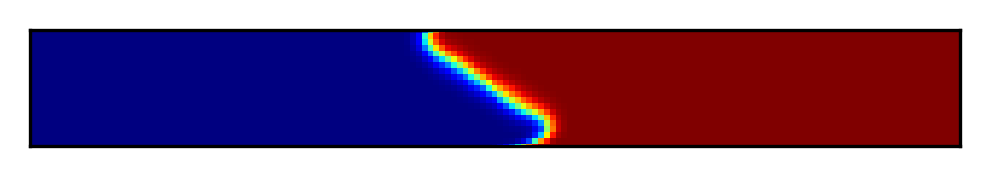

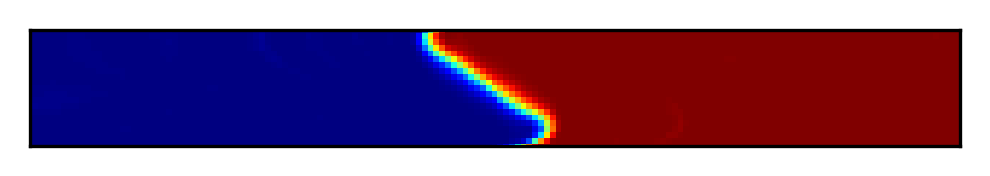

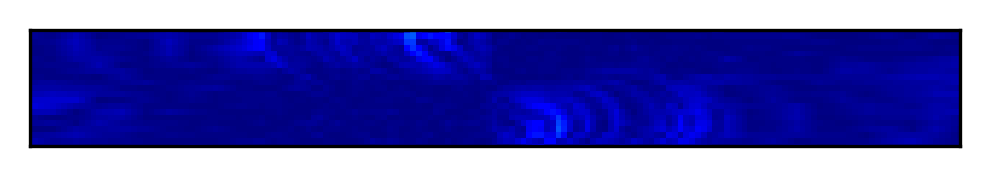

0.03954308208612611 3.757844037444169e-06


In [ ]:
ttt=100
grid_contour(temperature[ttt,:],coordinates,limit,'jet',[-0.5,0.5],30,0)
grid_contour(deco_sae_pod[ttt,:],coordinates,limit,'jet',[-0.5,0.5],30,0)
grid_contour(abs(temperature[ttt,:]-deco_sae_pod[ttt,:]),coordinates,limit,'jet',[0,0.15],30,0)
print(np.max(abs(temperature[ttt,:]-deco_sae_pod[ttt,:])),np.min(abs(temperature[ttt,:]-deco_sae_pod[ttt,:])))

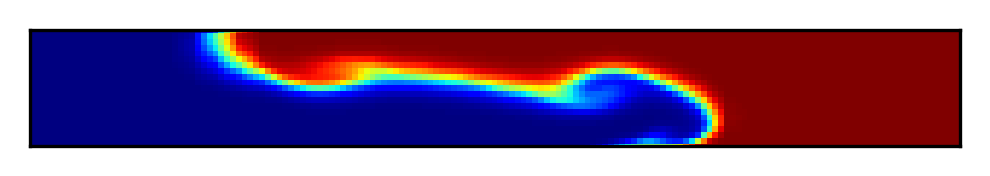

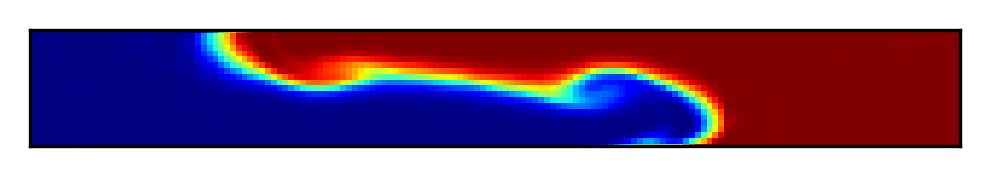

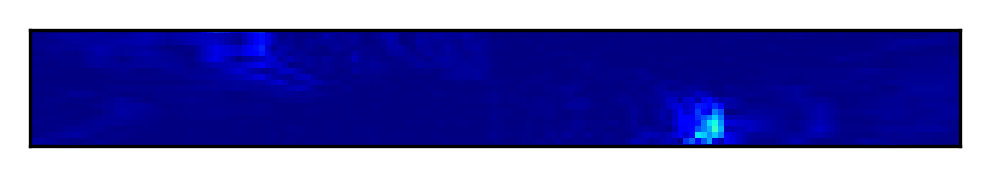

0.13813355444607 2.0557401356757765e-06


In [ ]:
ttt=348
grid_contour(temperature[ttt,:],coordinates,limit,'jet',[-0.5,0.5],30,0)
grid_contour(deco_sae_pod[ttt,:],coordinates,limit,'jet',[-0.5,0.5],30,0)
grid_contour(abs(temperature[ttt,:]-deco_sae_pod[ttt,:]),coordinates,limit,'jet',[0,0.30],30,0)
print(np.max(abs(temperature[ttt,:]-deco_sae_pod[ttt,:])),np.min(abs(temperature[ttt,:]-deco_sae_pod[ttt,:])))

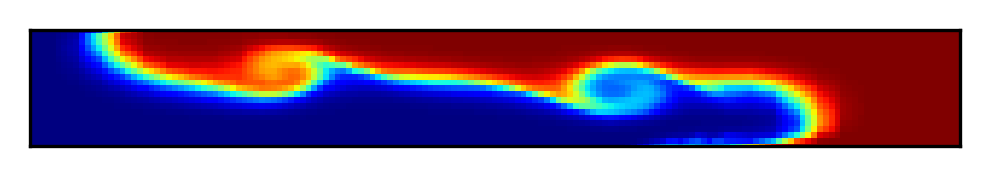

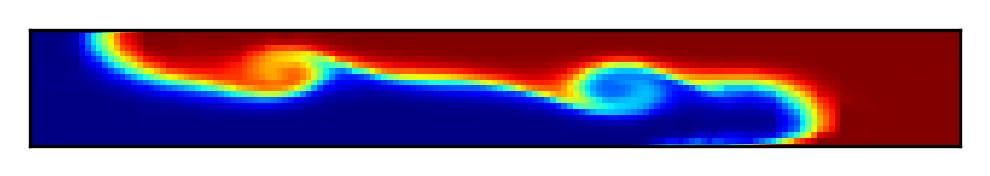

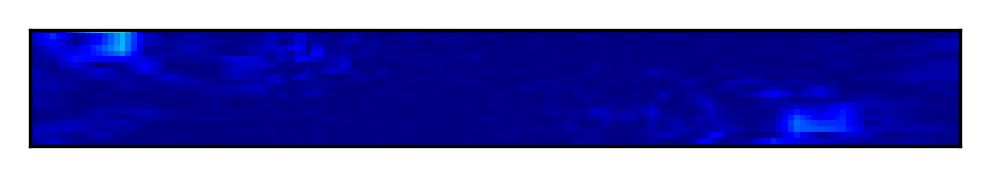

0.06553249572233705 1.4951180969391409e-06


In [ ]:
ttt=500
grid_contour(temperature[ttt,:],coordinates,limit,'jet',[-0.5,0.5],30,0)
grid_contour(deco_sae_pod[ttt,:],coordinates,limit,'jet',[-0.5,0.5],30,0)
grid_contour(abs(temperature[ttt,:]-deco_sae_pod[ttt,:]),coordinates,limit,'jet',[0,0.15],30,0)
print(np.max(abs(temperature[ttt,:]-deco_sae_pod[ttt,:])),np.min(abs(temperature[ttt,:]-deco_sae_pod[ttt,:])))

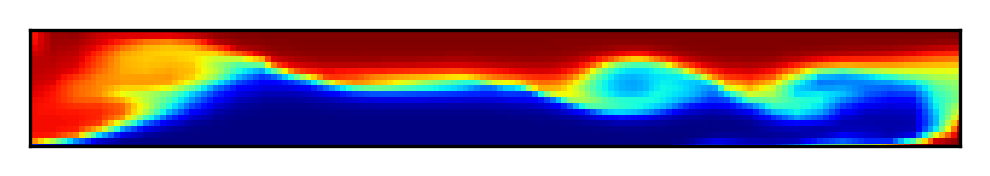

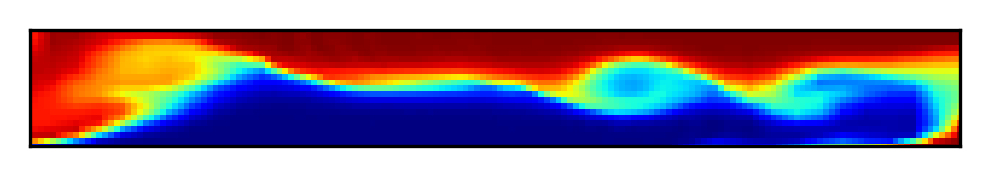

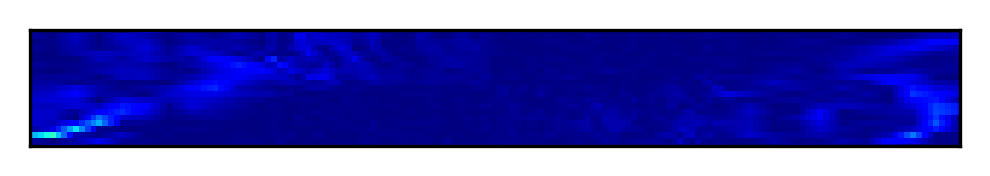

0.060383778878640104 6.196162638527625e-09


In [ ]:
ttt=750
grid_contour(temperature[ttt,:],coordinates,limit,'jet',[-0.5,0.5],30,0)
grid_contour(deco_sae_pod[ttt,:],coordinates,limit,'jet',[-0.5,0.5],30,0)
grid_contour(abs(temperature[ttt,:]-deco_sae_pod[ttt,:]),coordinates,limit,'jet',[0,0.15],30,0)
print(np.max(abs(temperature[ttt,:]-deco_sae_pod[ttt,:])),np.min(abs(temperature[ttt,:]-deco_sae_pod[ttt,:])))

### comparing

In [ ]:
deco_sae = np.load('./Model/deco_sae.npy')
deco_sae_pod = np.load('./Model/deco_sae_pod.npy')

In [ ]:
value = cp(temperature[1:799])
print(deco_sae.shape)
print(deco_sae_pod.shape)

deco1 = deco_sae
deco2 = deco_sae_pod

(798, 1491)
(798, 1491)


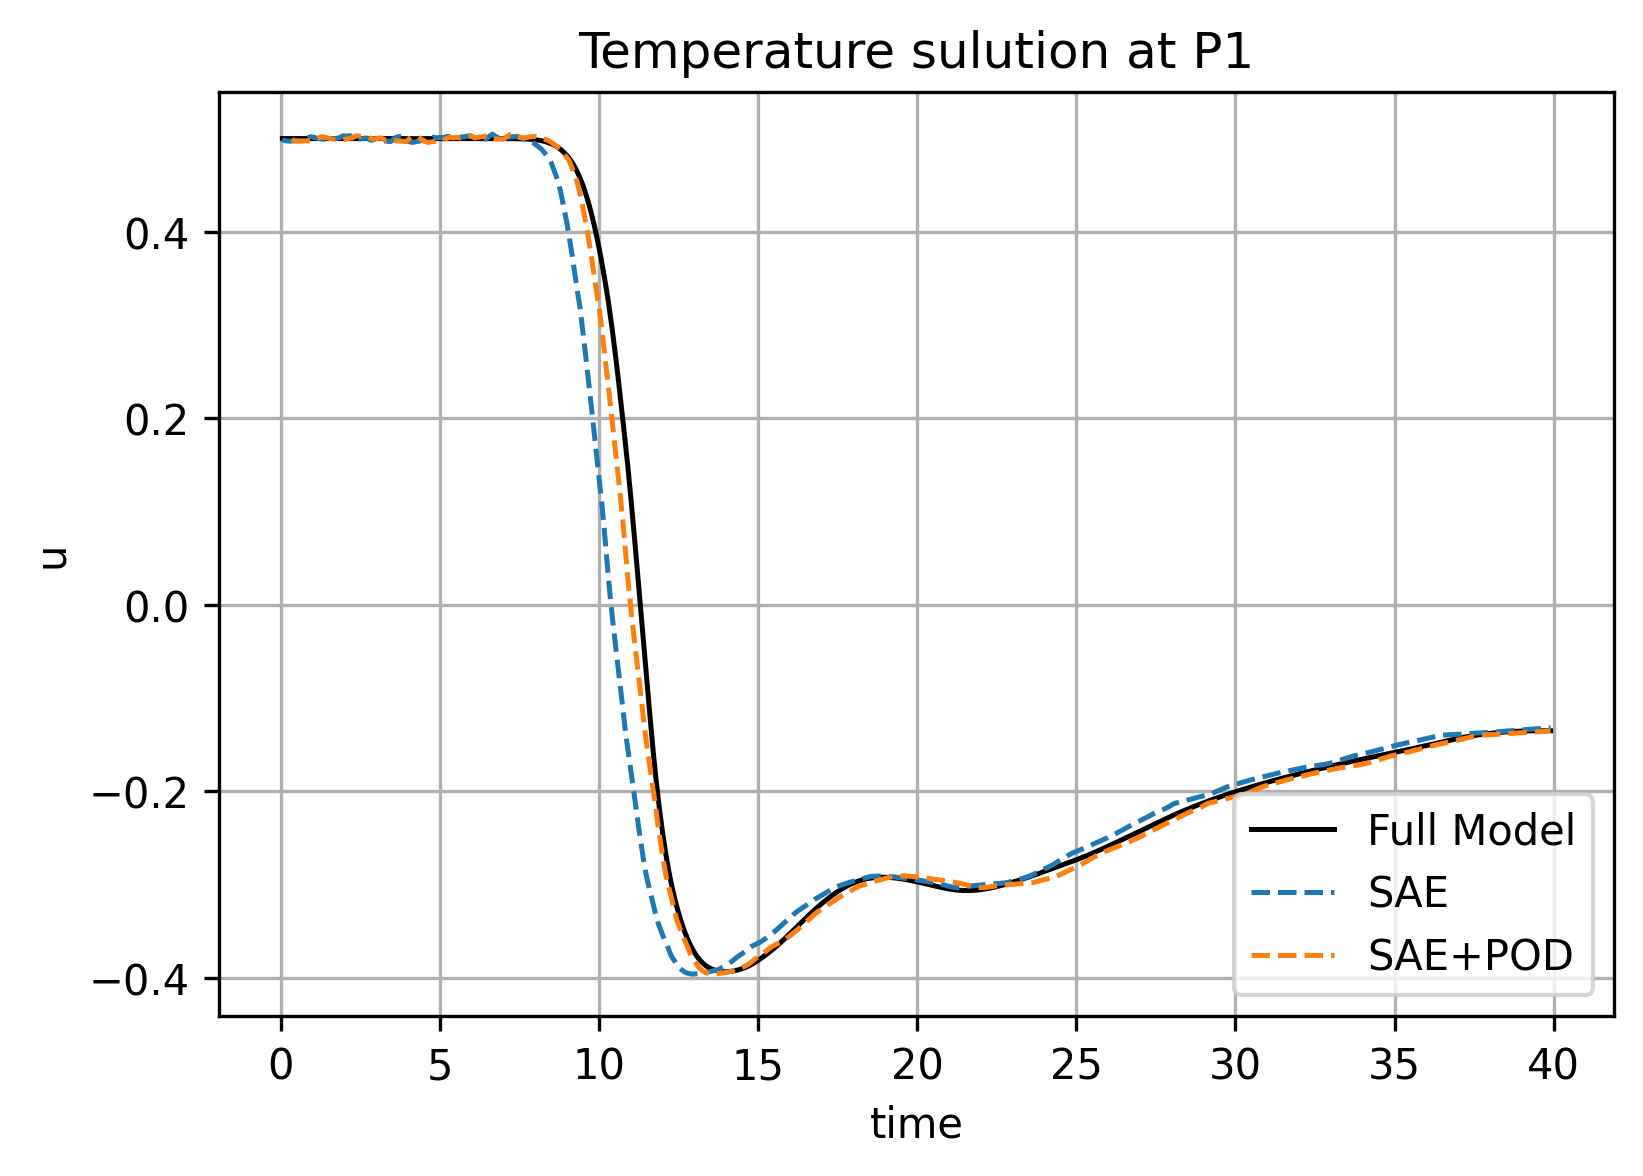

In [ ]:
fig=plt.figure(dpi=300,figsize=(6,4))
pt1 = 866
plt.plot(taxint[:],value[:,pt1],color='k',lw=1.2,label='Full Model')
plt.plot(taxint,deco1[:,pt1], '--',lw=1.2,label='SAE')
plt.plot(taxint[6:],deco2[:-6,pt1], '--',lw=1.2,label='SAE+POD') #,color='royalblue')      #'#ff7f0e')
plt.legend(loc='lower right')
# plt.xlim([60,80])
plt.xlabel('time')
plt.ylabel('u')
# plt.title('velocity vary in a partcicular point')
plt.title('Temperature sulution at P1')
plt.grid()

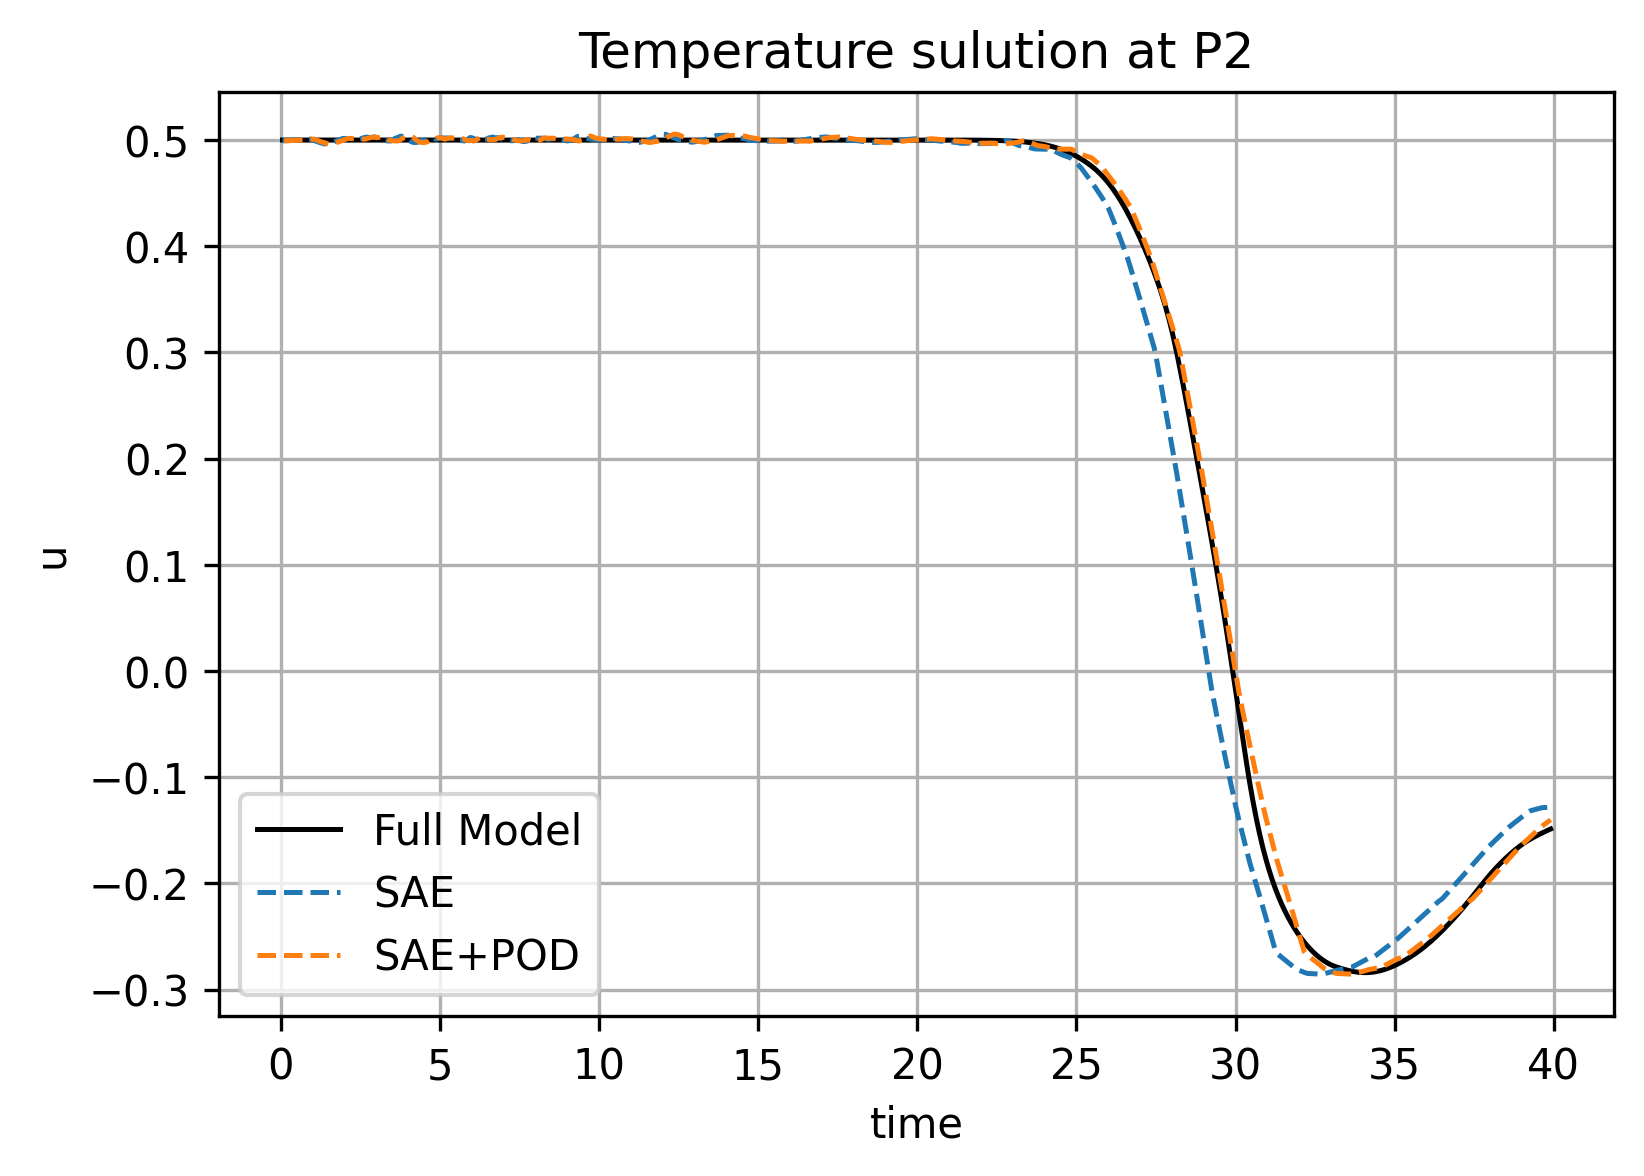

In [ ]:
fig=plt.figure(dpi=300,figsize=(6,4))
pt1 = 1405
plt.plot(taxint[:],value[:,pt1],color='k',lw=1.2,label='Full Model')
plt.plot(taxint,deco1[:,pt1], '--',lw=1.2,label='SAE')
plt.plot(taxint[1:],deco2[:-1,pt1], '--',lw=1.2,label='SAE+POD') #,color='royalblue')      #'#ff7f0e')
plt.legend(loc='lower left')
# plt.xlim([60,80])
plt.xlabel('time')
plt.ylabel('u')
# plt.title('velocity vary in a partcicular point')
plt.title('Temperature sulution at P2')
plt.grid()

In [ ]:
value = cp(temperature[1:799])
print(deco_sae.shape)
print(deco_sae_pod.shape)

deco1 = deco_sae
deco2 = deco_sae_pod

(798, 1491)
(798, 1491)


In [ ]:
pcc_sae = np.zeros((len(deco),))
pcc_sae_pod = np.zeros((len(deco),))
for i in range(len(deco)):
  pcc_sae[i] = stats.pearsonr(deco1[i,:], value[i,:])[0]
  pcc_sae_pod[i] = stats.pearsonr(deco2[i,:], value[i,:])[0]

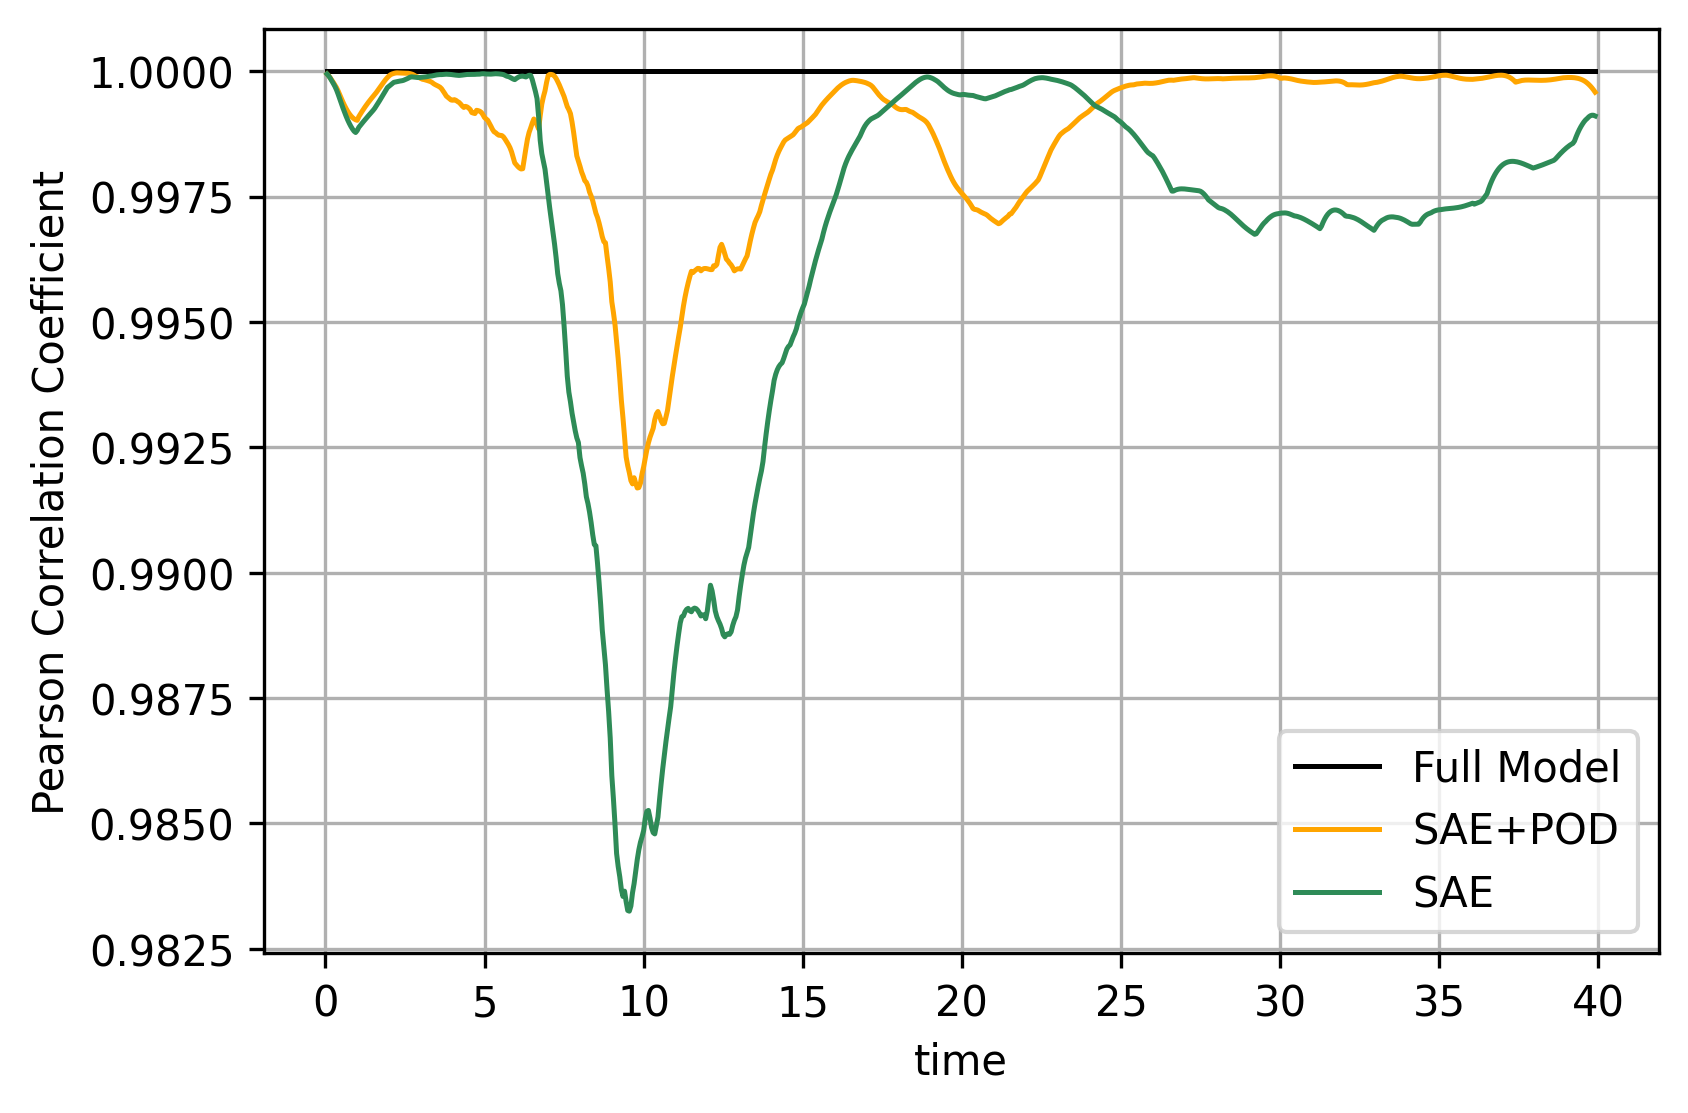

In [ ]:
fig=plt.figure(dpi=300,figsize=(6,4))
plt.plot(taxint[:],np.repeat(1,798),lw=1.2,label='Full Model',color='k')
plt.plot(taxint[:],pcc_sae_pod[:],lw=1.2,label='SAE+POD',color='orange')
plt.plot(taxint[:],pcc_sae[:],lw=1.2,label='SAE',color='seagreen')
# plt.plot(taxint[:],velocity_test[2:,pt1],color='k',lw=1,label='Full Model')
# plt.plot(taxint,deco_sae[:,pt1],'--',lw=1,label='SAE+POD')
# plt.plot(taxint[:],deco_sae_pod[2:,pt1],'--', lw=1,label='SAE') #,color='royalblue')      #'#ff7f0e')
plt.legend(loc='lower right')
# plt.yticks(ticks=[0.800,0.850,0.900,0.950,1.000],\
#                labels=['0.800','0.850','0.900','0.950','1.000'])
# plt.xlim([2,4.5])
# plt.ylim([0.8,1.02])
plt.xlabel('time')
plt.ylabel('Pearson Correlation Coefficient')
plt.grid()

In [ ]:
value = cp(temperature[1:799])
print(deco_sae.shape)
print(deco_sae_pod.shape)

deco1 = deco_sae
deco2 = deco_sae_pod

(798, 1491)
(798, 1491)


##### 2

In [ ]:
rmse_sae = np.zeros((len(deco),))
rmse_sae_pod = np.zeros((len(deco),))
for i in range(len(deco)-1):
  rmse_sae[i] = np.sqrt(((deco1[i,:]-value[i,:]) ** 2).mean())
  rmse_sae_pod[i] = np.sqrt(((deco2[i,:]-value[i+1
                                               ,:]) ** 2).mean())

print(np.max(rmse_sae_pod))

0.057057604766505954


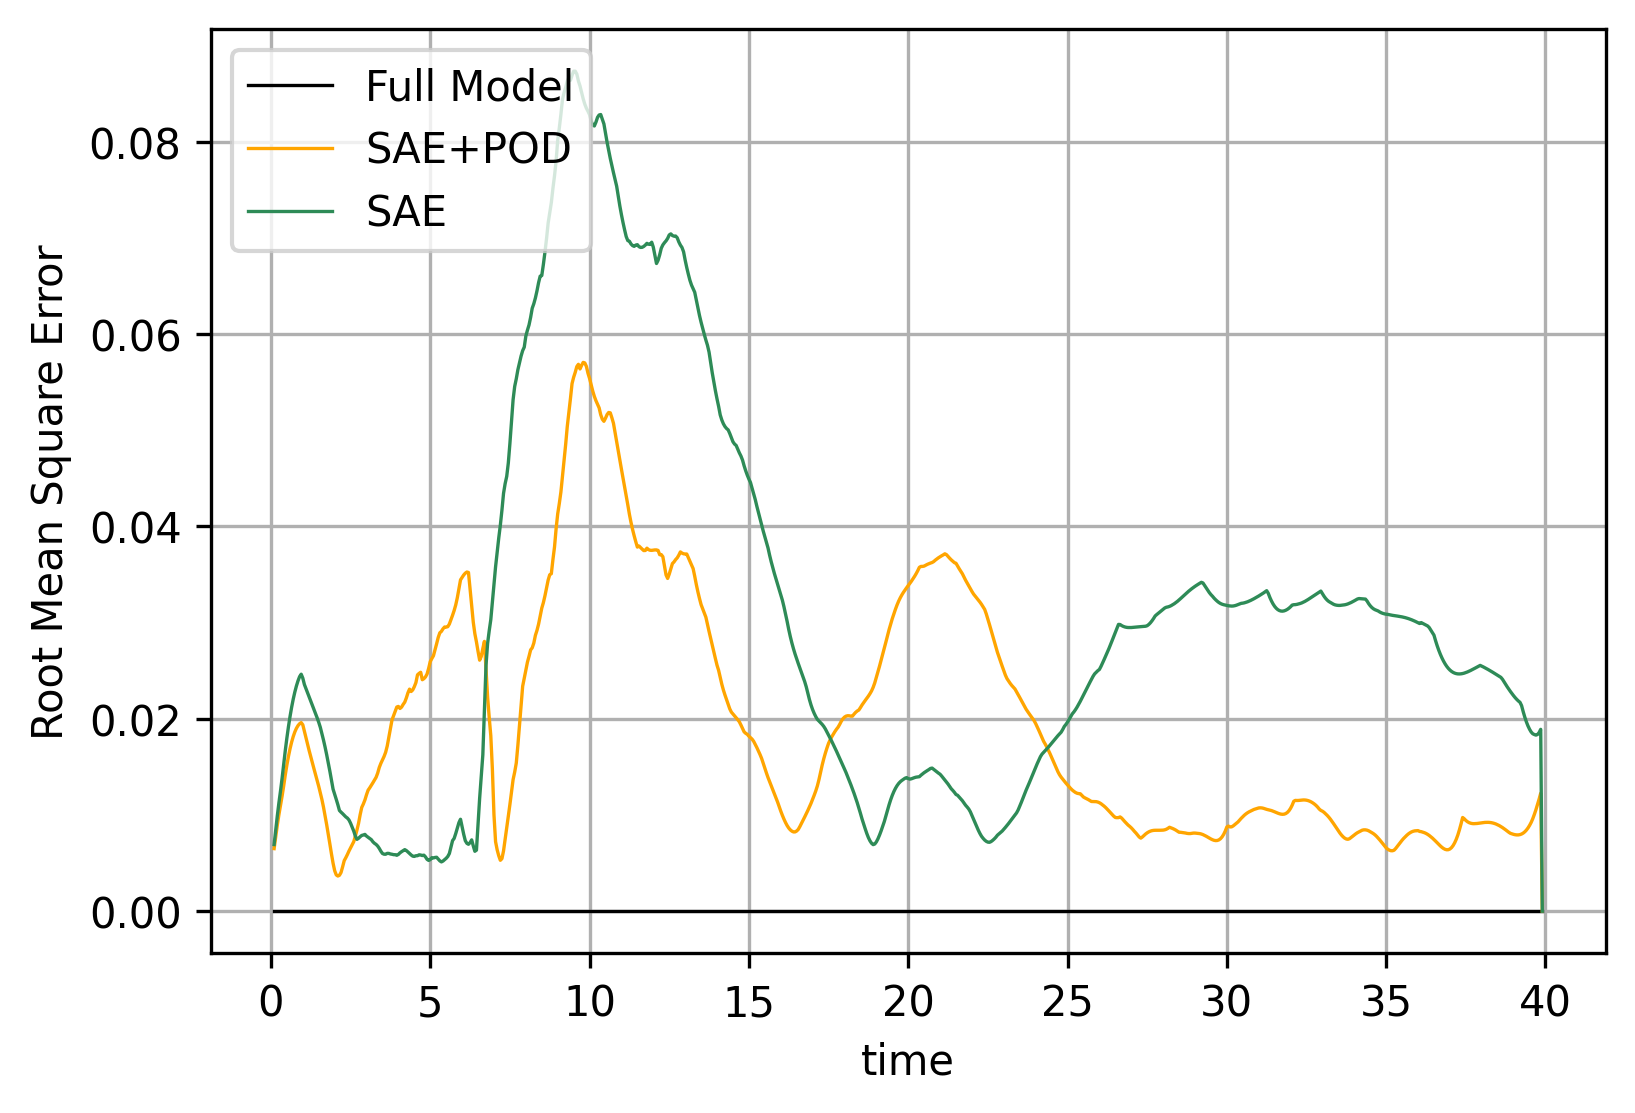

In [ ]:
fig=plt.figure(dpi=300,figsize=(6,4))
plt.plot(taxint[1:],np.repeat(0,798-1),lw=0.8,label='Full Model',color='k')
plt.plot(taxint[1:],rmse_sae_pod[1:],lw=0.8,label='SAE+POD',color='orange')
plt.plot(taxint[1:],rmse_sae[1:],lw=0.8,label='SAE',color='seagreen')
# plt.plot(taxint[:],velocity_test[2:,pt1],color='k',lw=1,label='Full Model')
# plt.plot(taxint,deco_sae[:,pt1],'--',lw=1,label='SAE+POD')
# plt.plot(taxint[:],deco_sae_pod[2:,pt1],'--', lw=1,label='SAE') #,color='royalblue')      #'#ff7f0e')
plt.legend(loc='upper left')
# plt.xlim([2,4.5])
# plt.ylim([0.8,1.02])
plt.xlabel('time')
plt.ylabel('Root Mean Square Error')
plt.grid()

##### 3

In [ ]:
rmse_sae = np.zeros((len(deco),))
rmse_sae_pod = np.zeros((len(deco),))
for i in range(len(deco)):
  rmse_sae[i] = np.sqrt(((deco1[i,:]-value[i,:]) ** 2).mean())
  rmse_sae_pod[i] = np.sqrt(((deco2[i,:]-value[i,:]) ** 2).mean())

print(np.max(rmse_sae_pod))

0.06149001524712134


In [ ]:
# 调整sae+pod的情况 把前两百个调整到0-0.2之间
rmse_sae_pod_min = np.min(rmse_sae_pod)
rmse_sae_pod_max = np.max(rmse_sae_pod)
for i in range(len(rmse_sae_pod)):
  rmse_sae_pod[i] = (rmse_sae_pod[i]-rmse_sae_pod_min)*0.06/(rmse_sae_pod_max-rmse_sae_pod_min)+0

### 概率分布直方图

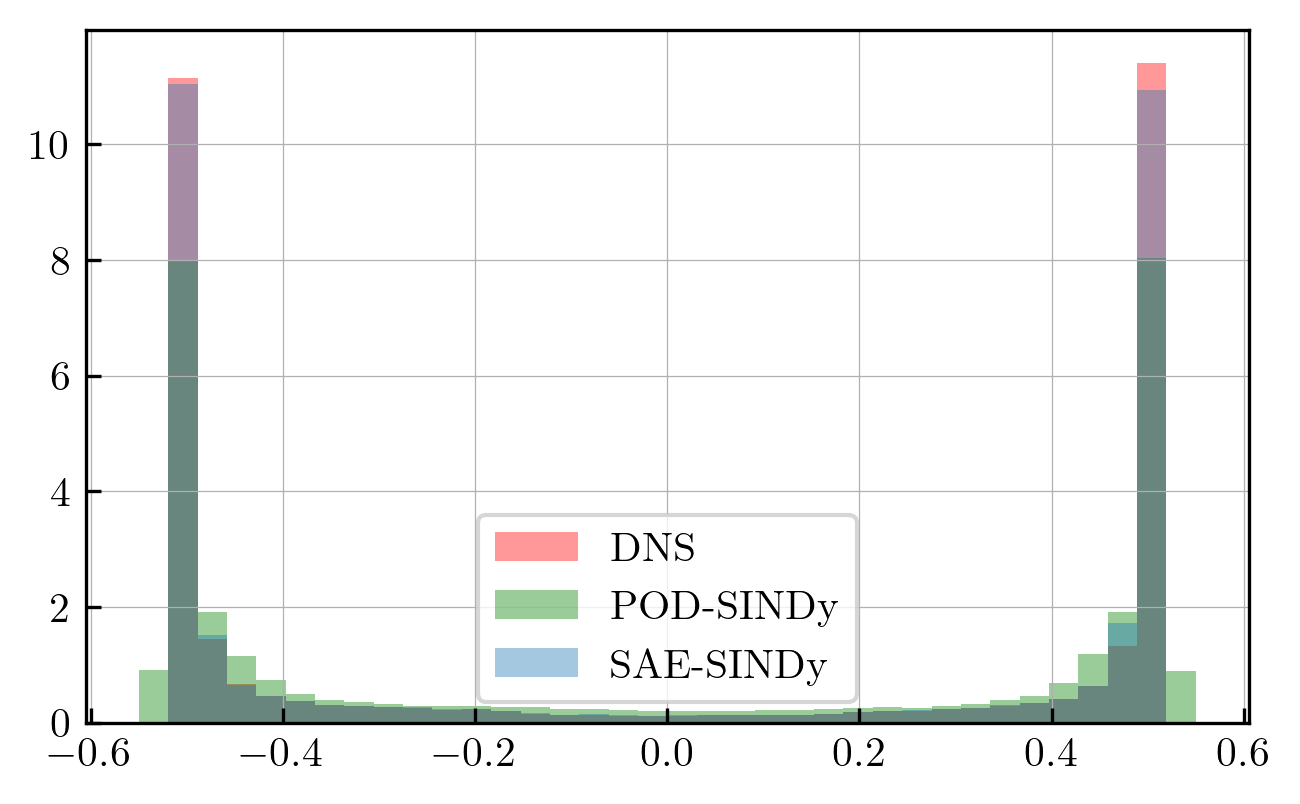

In [ ]:
vmin = -0.55
vmax = 0.55
binw = 0.03


fig=plt.figure(dpi=300,figsize=(5,3))

plt.grid(lw=0.3)

plt.hist(np.ravel(temperature),density=True,bins=int((vmax-vmin)/binw), alpha=0.4, color='r',range=(vmin,vmax),label='DNS')
# plt.hist(np.ravel(Un[1001:1001+1998,:,:]),density=True,bins=int((vmax-vmin)/binw), alpha=0.4, color='r',range=(vmin,vmax),label='DNS')
plt.hist(np.ravel(decof_pca),density=True,bins=int((vmax-vmin)/binw), alpha=0.4, color='g',range=(vmin,vmax),label='POD-SINDy')
plt.hist(np.ravel(deco),density=True,bins=int((vmax-vmin)/binw), alpha=0.4, color='#1f77b4',range=(vmin,vmax),label='SAE-SINDy')
# plt.hist(np.ravel(POD2rec[0:snapshots,:,:,uv]),bins=int((nmax-nmin)/binw)
#          , alpha=0.25, color='g',range=(nmin,nmax),normed=True,label='POD')
plt.legend()
plt.show()

### 还原图像

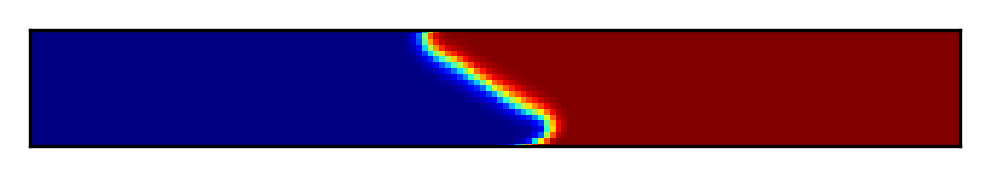

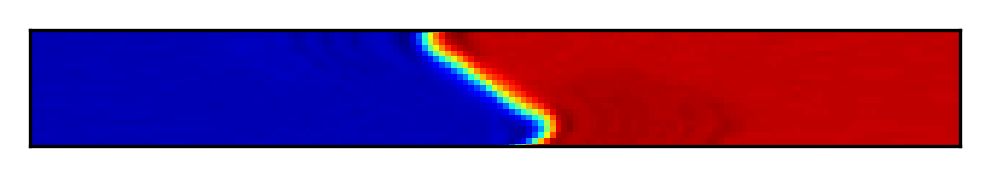

In [ ]:
grid_contour(temperature[100,:],coordinates,limit,'jet',None,30,0)
grid_contour(deco[99,:],coordinates,limit,'jet',None,30,0)

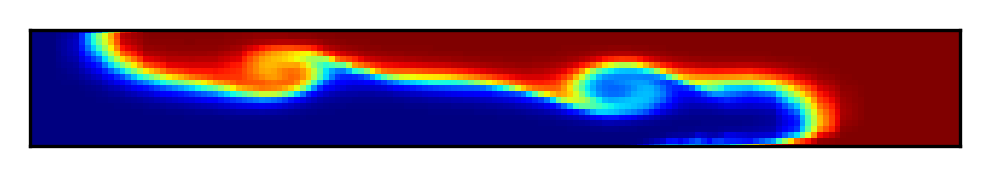

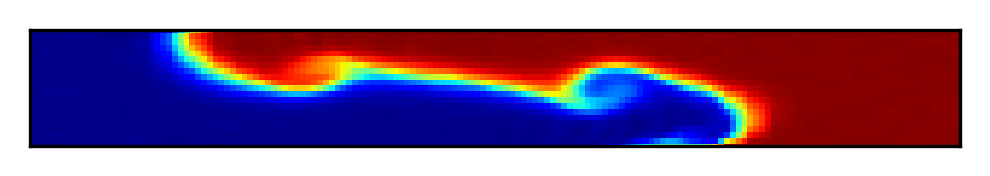

In [ ]:
grid_contour(temperature[500,:],coordinates,limit,'jet',None,30,0)
grid_contour(deco[400,:],coordinates,limit,'jet',None,30,0)

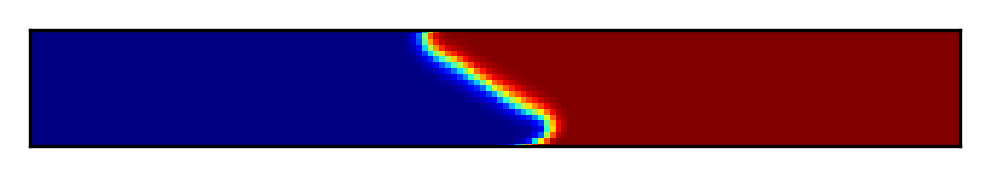

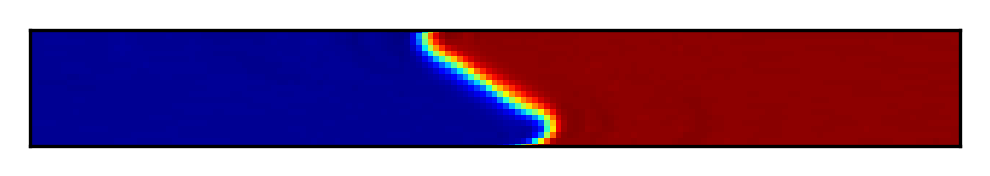

In [ ]:
filename = "/content/drive/MyDrive/fig/lock_exchange/lock_exchange_5s_ori.png"
grid_contour(temperature[100,:],coordinates,limit,'jet',None,30,0,1,filename)
# plt.savefig("/content/drive/MyDrive/fig/lock_exchange/lock_exchange_5s_ori.png")


filename = "/content/drive/MyDrive/fig/lock_exchange/lock_exchange_5s_reproduce.png"
grid_contour(deco[99,:],coordinates,limit,'jet',None,30,0,1,filename)
# plt.savefig("/content/drive/MyDrive/fig/lock_exchange/lock_exchange_5s_reproduce.png")

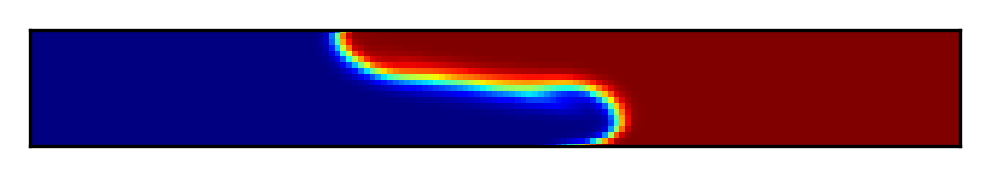

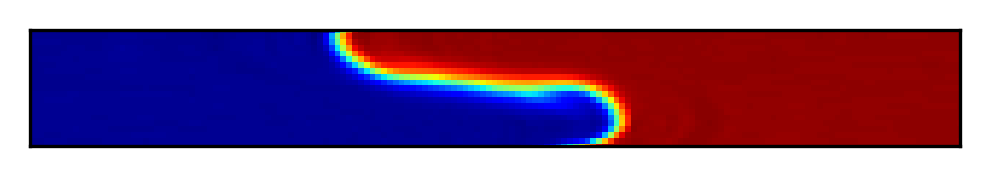

In [ ]:
filename = "/content/drive/MyDrive/fig/lock_exchange/lock_exchange_10s_ori.png"
grid_contour(temperature[200,:],coordinates,limit,'jet',None,30,0,1,filename)
# plt.savefig("/content/drive/MyDrive/fig/lock_exchange/lock_exchange_5s_ori.png")


filename = "/content/drive/MyDrive/fig/lock_exchange/lock_exchange_10s_reproduce.png"
grid_contour(deco[199,:],coordinates,limit,'jet',None,30,0,1,filename)
# plt.savefig("/content/drive/MyDrive/fig/lock_exchange/lock_exchange_5s_reproduce.png")

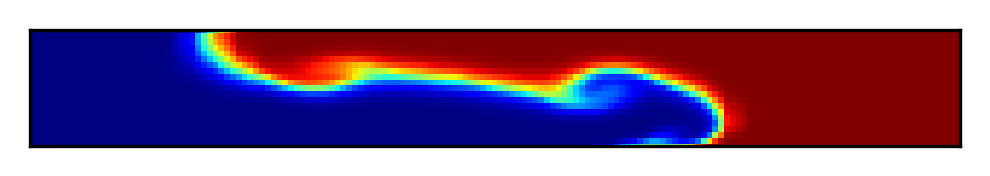

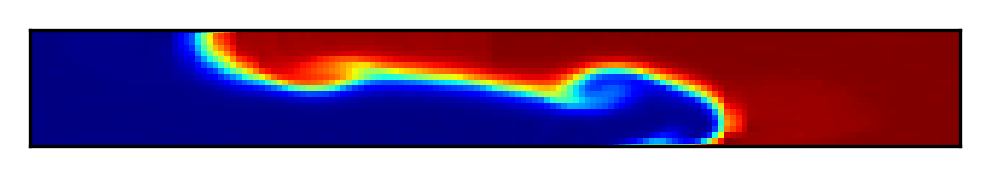

In [ ]:
filename = "/content/drive/MyDrive/fig/lock_exchange/lock_exchange_18s_ori.png"
grid_contour(temperature[360,:],coordinates,limit,'jet',None,30,0,1,filename)
# plt.savefig("/content/drive/MyDrive/fig/lock_exchange/lock_exchange_5s_ori.png")


filename = "/content/drive/MyDrive/fig/lock_exchange/lock_exchange_18s_reproduce.png"
grid_contour(deco[359,:],coordinates,limit,'jet',None,30,0,1,filename)
# plt.savefig("/content/drive/MyDrive/fig/lock_exchange/lock_exchange_5s_reproduce.png")

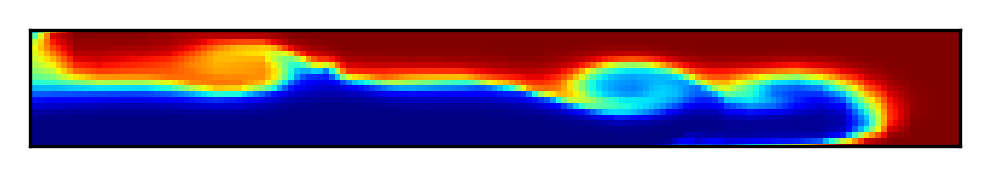

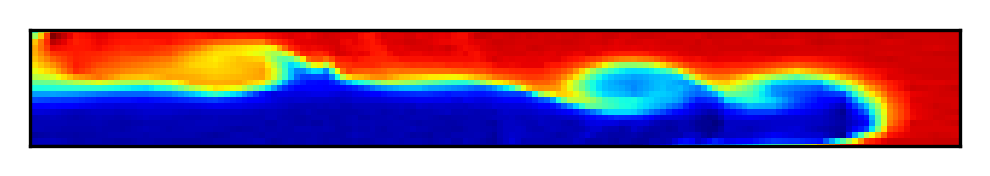

In [ ]:
filename = "/content/drive/MyDrive/fig/lock_exchange/lock_exchange_25s_ori.png"
grid_contour(temperature[599,:],coordinates,limit,'jet',None,30,0,1,filename)
# plt.savefig("/content/drive/MyDrive/fig/lock_exchange/lock_exchange_5s_ori.png")


filename = "/content/drive/MyDrive/fig/lock_exchange/lock_exchange_25s_reproduce.png"
grid_contour(deco[598,:],coordinates,limit,'jet',None,30,0,1,filename)
# plt.savefig("/content/drive/MyDrive/fig/lock_exchange/lock_exchange_5s_reproduce.png")